### Imports packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
import scipy.spatial.distance as distance
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from multiprocessing import Pool
import sys
import scipy.stats as stats
from scipy.optimize import minimize
import ot

In [2]:
def boxmuller(unif1,unif2):
    u1 = np.sqrt(-2*np.log(unif1))*np.cos(2*np.pi*unif2)
    u2 = np.sqrt(-2*np.log(unif1))*np.sin(2*np.pi*unif2)
    return np.transpose(np.vstack([u1,u2]))

# Function generating standard normals using the box-muller transformation:
def normals(n, d, unif, sv=False):

    # avoid origin
    unif[unif==0] = np.nextafter(0, 1)

    # if d is odd, add one dimension
    if d % 2 != 0:
        dim = d + 1
    else:
        dim = d

    # expand dimensions for SV model
    if sv == True:
        dim = 2+2*d

    # create standard normal samples
    u = np.zeros((n,dim))
    for i in np.arange(0,dim,2):
        u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

    # if d is odd, drop one dimension
    if d % 2 != 0 or sv == True:
        u = np.delete(u,-1,1)

    return u

def gen_gandk(z, theta):
    a = theta[0]
    b = theta[1]
    g = theta[2]
    k = np.exp(theta[3])
    g = a+b*(1+0.8*((1-np.exp(-g*z))/(1+np.exp(-g*z))))*((1+z**2)**(k))*z
    return g

def sample_gandk_outl(n,d,theta, n_cont = 0):
    
    cont_size = int(np.floor(int(n_cont)*5/100*n))
    n_real = n - cont_size

    # generate uniforms
    unif = np.random.rand(n_real,d+1)
    unif_outl = np.random.rand(cont_size,d+1)
  
    # generate standard normals  
    z = normals(n_real,d,unif)
    z_outl = normals(cont_size, d, unif_outl)

    # generate samples from g-and-k distribution
    if n_cont != 0:
        #theta_ = np.array([4,2,2,-np.log(3)])
        outl = gen_gandk(z_outl, theta) + 5
        sample = gen_gandk(z,theta)
        x = np.concatenate((sample, outl), axis=0)
    else:
        x = gen_gandk(z,theta)
    
    #outl = np.asmatrix(np.random.normal(loc=5,scale=1,size=cont_size)).transpose()

    return np.asarray(x), z   # need to return z as well?

def grad_gen_gandk(z,theta):
    a = theta[0]
    b = theta[1]
    g = theta[2]
    k = np.exp(theta[3])
    grad1 = np.ones(z.shape[0])
    grad2 = (1+(4/5)*((1-np.exp(-g*z))/(1+np.exp(-g*z))))*(np.exp(k*np.log(1+z**2)))*z
    grad3 = (8/5)*theta[1]*((np.exp(g*z))/(1+np.exp(g*z))**2)*(np.exp(k*np.log(1+z**2)))*z**2
    grad4 = b*(1+0.8*((1-np.exp(-g*z))/(1+np.exp(-g*z))))*(np.exp(k*np.log(1+z**2)))*np.log(1+z**2)*z
    return np.expand_dims(np.einsum('ij->ji',np.c_[grad1,grad2,grad3,grad4]), axis=0)

In [3]:
theta_star = np.array([3,1,1,-np.log(2)]) 
n = 5000
outl = 3
x = np.zeros((outl,n))
for i in range(outl):
    x[i,:] = np.squeeze(sample_gandk_outl(n,1,theta_star,i)[0])

In [4]:
def plot_gandk(x,outl,fig_size,theta):

#   # check generator
#   rng = np.arange(0.01,1,0.01)
#   z_rng = stats.norm.ppf(rng, loc=0, scale=1)
#   plt.figure(figsize=fig_size)
#   plt.plot(rng,gen_gandk(z_rng,theta))
#   plt.title('Quantile function')
#   plt.xlabel(r'$u$')
#   plt.ylabel(r'$G_\theta(u)$')
#   plt.savefig('generator.pdf')
#   plt.show()

  # plot histogram
    fig, ax_array = plt.subplots(outl, 1, figsize=fig_size)
    for j,ax in enumerate(ax_array):
        ax.hist(x[j,:], bins=np.linspace(np.min(x[j,:]), np.max(x[j,:]),100), density=True)
        ax.set_title('Histogram for {} % of outliers'.format(j*5))
        ax.set_xlabel('x')
        ax.set_ylabel('density')
    fig.tight_layout() 
    #fig.savefig('histogram_gandk.png')
    return fig, ax_array

In [5]:
def MMD(theta,data,kxx,l):
    n=2**11
    m=2**9
    d=1
    s=1
    weights = dirichlet.rvs(np.ones(n), size = 1).flatten()
    #weights = np.ones(n)
    #sample = sample_gaussian_outl('MC',m,d,s,theta)
    sample = sample_gandk_outl(m,d,theta)[0]
    kyy, k1yy, k2yy = k(sample,sample,l)
    kxy, k1xy = k(sample,data,l)[0:2]    #kyx
        
    # first sum
    np.fill_diagonal(kyy, np.repeat(0,m)) # exclude k(y_i, y_i) (diagonal terms)
    sum1 = np.sum(kyy)
    
    # second sum
    #sum2 = np.sum(kxy)
    sum2 = np.sum(kxy*weights)
    
    # third sum
    np.fill_diagonal(kxx, np.repeat(0,n))
    #sum3 = np.sum(self.kxx)
    sum3 = np.sum(kxx*weights)
    
    #return (1/(m*(m-1)))*sum1-(2/(m*n))*sum2+(1/(n*(n-1)))*sum3
    return (1/(m*(m-1)))*sum1-(2/(m))*sum2+(1/(n-1))*sum3

In [6]:
n=2**11
d=1
s=1
n_cont = 0
theta_star=np.ones(d)
data = sample_gaussian_outl(n,d,s,theta_star,n_cont=n_cont) 
l = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
kxx = k(data,data,l)[0]
thetas = np.linspace(-10,10,100)
MMDs = []
for i, t in enumerate(thetas):
    MMDs.append(MMD(t,data,kxx,l))
plt.plot(thetas, MMDs)

NameError: name 'sample_gaussian_outl' is not defined

In [7]:
n=2**11
d=1
s=1
p=4
n_cont = 1
theta_star=np.array([3,1,1,-np.log(2)]) 
data = sample_gandk_outl(n,d,theta_star,n_cont=n_cont)[0] 
#l = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
l=0.1
kxx = k(data,data,l)[0]
thetas = np.zeros((p,100))
theta1 = np.linspace(-10,10,100)
thetas[0,:] = 3*np.ones(100)
thetas[1,:] = np.ones(100)
thetas[2,:] = theta1 #np.ones(100)
thetas[3,:] = -np.log(2)*np.ones(100)
MMDs = []

for i in range(100):
    t = thetas[:,i]
    MMDs.append(MMD(t,data,kxx,l))
    #print(MMDs)
plt.plot(thetas[2,:], MMDs)
plt.axvline(theta_star[2])
# fig, ax_array = plt.subplots(2,2, figsize=(10,10))
# for ax, i in zip(ax_array.flatten(), range(0, p * n_cont)):
#     ax.plot(thetas[i,:], MMDs)
#     ax.set_xlabel('theta_{}'.format(i))
# fig, ax_array

NameError: name 'k' is not defined

In [8]:
theta_star[3]

-0.6931471805599453

(<Figure size 504x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff065038dd0>,
       dtype=object))

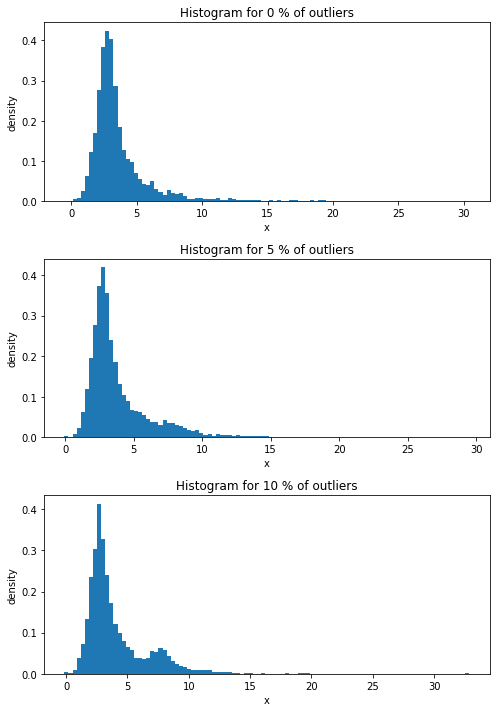

In [9]:
plot_gandk(x,3,(7,10),theta_star)

### Data simulation: $(X_1,\dots,X_n)$.

In [10]:
# Sample a dataset of size n from univariate Gaussians with a portion of outliers
def datagen(n,theta,contamination = []):
    datag = np.random.normal(loc=theta,scale=1,size=n-np.size(contamination))
    datag = np.concatenate((datag,contamination),axis=0)
    return np.matrix(datag)

## Box-Muller transformation

Box-Muller transformation:

In [11]:
def boxmuller(unif1,unif2):
    u1 = np.sqrt(-2*np.log(unif1))*np.cos(2*np.pi*unif2)
    u2 = np.sqrt(-2*np.log(unif1))*np.sin(2*np.pi*unif2)
    return np.transpose(np.vstack([u1,u2]))

Function generating standard normals using the box-muller transformation:

In [12]:
def normals(n, d, unif, sv=False):

    # avoid origin
    unif[unif==0] = np.nextafter(0, 1)

    # if d is odd, add one dimension
    if d % 2 != 0:
        dim = d + 1
    else:
        dim = d

    # expand dimensions for SV model
    if sv == True:
        dim = 2+2*d

    # create standard normal samples
    u = np.zeros((n,dim))
    for i in np.arange(0,dim,2):
        u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

    # if d is odd, drop one dimension
    if d % 2 != 0 or sv == True:
        u = np.delete(u,-1,1)

    return u

### Gaussian Kernel
Gaussian kernel $k(x,y)$, its gradient w.r.t. first element $\nabla_1k(x,y)$ and its second derivative w.r.t. to the second and first argument $\nabla_2\nabla_1k(x,y)$:

In [13]:
def k(x,y,l, sparse=False): 

    if sparse == True:
        x = x.astype('float32')
        y = y.astype('float32')
    
    # dimensions
    d = x.shape[1]
    dims = np.arange(d)
    
    # kernel
    kernel = np.exp(-(1/(2*l**2))*distance.cdist(x,y,'sqeuclidean'))
    
    if type(x) != np.ndarray: # using np.matrix.A to convert to ndarray
        x = x.A
    if type(y) != np.ndarray:
        y = y.A
    
    # first derivative
    grad_1 = -1*np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0)*(1/l**2)*np.expand_dims(kernel, axis=0)
    
    #second derivative
    grad_21 = (1/l**2)*(np.expand_dims(np.expand_dims(np.eye(d), axis = 2), axis = 3)-np.einsum('ijk,ljk->iljk',np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0),np.squeeze(np.subtract.outer(x,y)[:,[dims],:,[dims]], axis=0))*(1/l**2))*kernel
    
    return list([kernel, grad_1, grad_21])

### $MMD^2$ approximation

In [14]:
def MMD_approx(n,m,weights,kxx,kxy,kyy):
        """y_{i=1}^m iid from P_\theta, x_{i=1}^n iid from P_0
        kxx is nxn, kyy is mxm and kxy is nxm"""
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,m)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        #sum2 = np.sum(kxy)
        sum2 = np.sum(kxy*weights)
    
        # third sum
        np.fill_diagonal(kxx, np.repeat(0,n))
        #sum3 = np.sum(self.kxx)
        sum3 = np.sum(kxx*weights)
    
        #return (1/(m*(m-1)))*sum1-(2/(m*n))*sum2+(1/(n*(n-1)))*sum3
        return (1/(m*(m-1)))*sum1-(2/(m))*sum2+(1/(n-1))*sum3

In [15]:
def MMD_to_minimise(data,m,weights,kxx,n,d,s,p):
    
    l = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
    def MMD(theta):
        np.random.seed(11)
        sample = sample_gaussian_outl('MC',m,d,s,theta)
        kyy, k1yy, k2yy = k(sample,sample,l)
        kxy, k1xy = k(sample,data,l)[0:2]    #kyx
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,m)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        #sum2 = np.sum(kxy)
        sum2 = np.sum(kxy*weights)
    
        # third sum
        np.fill_diagonal(kxx, np.repeat(0,n))
        #sum3 = np.sum(self.kxx)
        sum3 = np.sum(kxx*weights)
    
        #return (1/(m*(m-1)))*sum1-(2/(m*n))*sum2+(1/(n*(n-1)))*sum3
        return (1/(m*(m-1)))*sum1-(2/(m))*sum2+(1/(n-1))*sum3
    
    def mmd_grad(theta):
        np.random.seed(11)
        #def grad_MMD(p,n,m,grad_g,weights,k1yy,k1xy):
        sample = sample_gaussian_outl('MC',m,d,s,theta)
        kyy, k1yy, k2yy = k(sample,sample,l)
        kxy, k1xy = k(sample,data,l)[0:2]    #kyx
        # grad_g 
        arg1 = np.expand_dims(np.eye(theta.shape[0]),axis=2)
        arg2 = (theta.shape[0],theta.shape[0],m)
        grad_g = np.broadcast_to(arg1,arg2) 
        # first sum
        prod1 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1yy,axis=1)))
        if prod1.ndim==2:
            np.fill_diagonal(prod1[:,:], 0)
            sum1 = np.sum(prod1)
        else:
            for i in range(p):
                np.fill_diagonal(prod1[i,:,:], 0)
            sum1 = np.einsum('ijk->i',prod1)
    
        # second sum
        for i in range(d):
            k1xy[i,:,:] = k1xy[i,:,:]*weights
        #k1xy[1,:,:] = k1xy[1,:,:]*weights
        prod2 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1xy,axis=1)))
        if prod2.ndim==2:
            sum2 = np.sum(prod2)
        else:
            sum2 = np.einsum('ijk->i',prod2)
    
        #return (2/(m*(m-1)))*sum1-(2/(n*m))*sum2
        return (2/(m*(m-1)))*sum1-(2/(m))*sum2
    
    optimization_result = minimize(MMD, np.zeros(d), 
                           method= 'BFGS', options={'disp': True}) #jac=mmd_grad
        

        
    # return the value at optimum
    return optimization_result.x
    
    

### MMD$^2$ gradient approximation between $P_{\theta}$ and $\sum_{i=1}^n w_i \delta_{x_i}$:

In [16]:
def grad_MMD(p,n,m,grad_g,weights,k1yy,k1xy):
    
    # first sum
    prod1 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1yy,axis=1)))
    if prod1.ndim==2:
        np.fill_diagonal(prod1[:,:], 0)
        sum1 = np.sum(prod1)
    else:
        for i in range(p):
            np.fill_diagonal(prod1[i,:,:], 0)
        sum1 = np.einsum('ijk->i',prod1)
    
    # second sum
    for i in range(d):
        k1xy[i,:,:] = k1xy[i,:,:]*weights
   
    prod2 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1xy,axis=1)))
    if prod2.ndim==2:
        sum2 = np.sum(prod2)
    else:
        sum2 = np.einsum('ijk->i',prod2)
    
    #return (2/(m*(m-1)))*sum1-(2/(n*m))*sum2
    return (2/(m*(m-1)))*sum1-(2/(m))*sum2

## Information metric

Approximation of the informatin metric $g_U(\theta)$:

In [17]:
def g_approx(p,m,grad_g,k21xx):
    
    # sum
    grad_g_T = np.einsum('ijk -> jik',grad_g)
    prod1 = np.einsum('ijk, jlkm -> ilkm', grad_g_T, k21xx)
    prod2 = np.einsum('ijkl,jmk->imkl', prod1, grad_g)
    for i in range(p):
        np.fill_diagonal(prod2[i,i,:,:], 0)
    gsum = np.einsum('ijkl->ij', prod2)
    
    return 1/(m*(m-1))*gsum

## Generator

Generator $G_\theta(u)$ and generator gradient $\nabla_\theta G_\theta(u)$ for the **Gaussian location model**:

In [18]:
# generator
def gen_gaussian(n, d, unif, theta, sigma):

    unif[unif==0] = np.nextafter(0, 1)

    # if d is odd, add one dimension
    if d % 2 != 0:
        dim = d + 1
    else:
        dim = d

    # create standard normal samples
    u = np.zeros((n,dim))
    for i in np.arange(0,dim,2):
        u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

    # if d is odd, drop one dimension
    if d % 2 != 0:
        u = np.delete(u,-1,1)

    # generate samples
    x = theta + u*sigma

    return x

# gradient of the generator
def grad_gen_gaussian(m, theta):
    arg1 = np.expand_dims(np.eye(theta.shape[0]),axis=2)
    arg2 = (theta.shape[0],theta.shape[0],m)
    return np.broadcast_to(arg1,arg2)    

Function to sample from **Gaussian location model**:



In [19]:
def sample_gaussian_outl(method_sampling,n,d,s,theta,n_cont = 0):   # set n_cont to zero if you don't want outliers

    ' caveat:                                                                 '
    ' the qmc or qmc_1 sequence have to be fixed before using this function   '
    
    cont_size = int(np.floor(int(n_cont)*5/100*n))
    n_real = n - cont_size
    
    # odd number of parameters
    if d % 2 != 0: 
        if method_sampling == 'MC':
            unif = np.random.rand(n_real,d+1)
        if method_sampling == 'QMC':
            unif = qmc_1.gen_samples(n_real)
        if method_sampling == 'RQMC':
            unif = qmcpy.Halton(d+1).gen_samples(n_real)

    # even number of parameters
    else: 
        if method_sampling == 'MC':
            unif = np.random.rand(n_real,d)
        if method_sampling == 'QMC':
            unif = qmc.gen_samples(n_real)
        if method_sampling == 'RQMC':
            unif = qmcpy.Halton(d).gen_samples(n_real)

    # use generator  
    if n_cont != 0:
        outl = np.asmatrix(np.random.normal(loc=5,scale=1,size=cont_size)).transpose()
        sample_ = gen_gaussian(n_real,d,unif,theta,s) 
        x = np.concatenate((sample_, outl), axis=0)
    else:
        x = gen_gaussian(n_real,d,unif,theta,s)
        
    return x

### Computation of the Maximum Likelihood Estimator (the mean) $\frac{1}{n}\sum_{i=1}^n X_i$ and the geometric median

In [20]:
def MLE(data):
    return(np.mean(data))

In [21]:
def GEO_MED(data):
    return(np.median(data))

### NPL
For Generative models

In [22]:
class NPL():
    """This class contains everything that is needed for inference with a 
    given model. 
    """
    
    def __init__(self, X, B, m, s, p, l, method_gd = 'SGD'):
        self.B = B  # number of bootstrap iterations
        self.m = m  # number of points sampled from P_\theta at each optim. iteration
        self.s = s  # standard deviation of the model 
        self.p = p  # number of unknown parameters
        self.X = X  # data
        self.n, self.d = self.X.shape   # dims of data
        self.method_gd = method_gd # optim. method: SGD or NSGD
        self.l = l  # lengthscale of gaussian kernel
        # median heuristic if l=-1 
        if self.l == -1:
            self.l = np.sqrt((1/2)*np.median(distance.cdist(self.X,self.X,'sqeuclidean')))
        self.kxx = k(self.X,self.X,self.l)[0]
        
        
    def draw_single_sample(self, bootstrap_it):
        
        # draw Dirichlet weights
        weights = dirichlet.rvs(np.ones(self.n), size = 1).flatten()   # ranodm state?
        # compute WLL minimizer
        wll_j = self.WLL(self.X, weights)  
        # compute MMD minimizer
        theta_j, loss_j, gd_losses_j = self.minimise_MMD(self.X, weights)    
        
        return theta_j, wll_j, loss_j, gd_losses_j
        
    
    def draw_samples(self, seed=0):
        """Draws B samples from the nonparametric posterior specified via
        the likelihood and the data X"""
        
        print("Drawing samples...")    
        
        sample = np.zeros((self.B,self.p))
        wll = np.zeros((self.B,self.p))
        mmd_loss = np.zeros((self.B,self.p))
        
        # Parallelize
        # temp = Parallel(n_jobs=-1, backend= 'loky', max_nbytes = "50M" )(delayed(self.draw_single_sample)(X, self.n) for j in tqdm(range(self.B)))  
        if __name__ == '__main__':
            pool = Pool()               # Create a multiprocessing Pool - defualt arg. is max number of n_cores
            temp = pool.map(self.draw_single_sample, tqdm(range(self.B))) 
        
        for i in range(self.B):
            sample[i,:] = temp[i][0]
            wll[i,:] = temp[i][1]
            mmd_loss[i,:] = temp[i][2]
            # gd_losses
                    
        self.sample = np.array(sample)
        self.wll = np.array(wll)
        self.mmd_loss = np.array(mmd_loss)
    
    # generator
    def gen_gaussian(self, unif, theta):

        unif[unif==0] = np.nextafter(0, 1)

        # if d is odd, add one dimension
        if self.d % 2 != 0:
            dim = self.d + 1
        else:
            dim = self.d

        # create standard normal samples
        u = np.zeros((self.m,dim))
        for i in np.arange(0,dim,2):
            u[:,i:(i+2)] = boxmuller(unif[:,i],unif[:,(i+1)])

        # if d is odd, drop one dimension
        if self.d % 2 != 0:
            u = np.delete(u,-1,1)

       # generate samples
        x = theta + u*self.s

        return x

    # gradient of the generator
    def grad_gen_gaussian(self,theta):
        return np.broadcast_to(np.expand_dims(np.eye(theta.shape[0]),axis=2),(theta.shape[0],theta.shape[0],self.m))
    
    def g_approx(self,grad_g, k2yy):
        # sum
        grad_g_T = np.einsum('ijk -> jik',grad_g)
        prod1 = np.einsum('ijk, jlkm -> ilkm', grad_g_T, k2yy)
        prod2 = np.einsum('ijkl,jmk->imkl', prod1, grad_g)
        for i in range(self.p):
            np.fill_diagonal(prod2[i,i,:,:], 0)
        gsum = np.einsum('ijkl->ij', prod2)
    
        return 1/(self.m*(self.m-1))*gsum

    def sample_gaussian(self,method_sampling,theta):

        ' caveat:                                                                 '
        ' the qmc or qmc_1 sequence have to be fixed before using this function   '

        # odd number of parameters
        if self.d % 2 != 0: 
            if method_sampling == 'MC':
                unif = np.random.rand(self.m,self.d+1)
            if method_sampling == 'QMC':
                unif = qmc_1.gen_samples(self.m)
            if method_sampling == 'RQMC':
                unif = qmcpy.Halton(d+1).gen_samples(self.m)

        # even number of parameters
        else: 
            if method_sampling == 'MC':
                unif = np.random.rand(self.m,self.d)
            if method_sampling == 'QMC':
                unif = qmc.gen_samples(self.m)
            if method_sampling == 'RQMC':
                unif = qmcpy.Halton(d).gen_samples(self.m)

        # use generator  
        x = self.gen_gaussian(unif,theta)

        return x
    
    def MMD_approx(self,weights,kxy,kyy):
        """y_{i=1}^n iid from P_\theta, x_{i=1}^m iid from Q
        kxx is nxn, kyy is mxm and kxy is nxm"""
        
        # first sum
        np.fill_diagonal(kyy, np.repeat(0,self.m)) # exclude k(y_i, y_i) (diagonal terms)
        sum1 = np.sum(kyy)
    
        # second sum
        sum2 = np.sum(kxy*weights)
    
        # third sum
        np.fill_diagonal(self.kxx, np.repeat(0,self.n))
        kxx = self.kxx*weights
        sum3 = np.sum(kxx)
    
        return (1/(self.m*(self.m-1)))*sum1-(2/(self.m*self.n))*sum2+(1/(self.n*(self.n-1)))*sum3
    
    
    def grad_MMD(self,weights,grad_g,k1yy,k1xy):
        # y sample from p_theta, x data
        # first sum
        prod1 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1yy,axis=1)))
        if prod1.ndim==2:
            np.fill_diagonal(prod1[:,:], 0)
            sum1 = np.sum(prod1)
        else:
            for i in range(self.p):
                np.fill_diagonal(prod1[i,:,:], 0)
            sum1 = np.einsum('ijk->i',prod1)

        # second sum
        k1xy[0,:,:] = k1xy[0,:,:]*weights
        # 
        prod2 = np.squeeze(np.einsum('ilj,imjk->lmjk', grad_g, np.expand_dims(k1xy,axis=1)))
        if prod2.ndim==2:
            sum2 = np.sum(prod2)
        else:
            sum2 = np.einsum('ijk->i',prod2)
    
        return (2/(self.m*(self.m-1)))*sum1-(2/(self.n*self.m))*sum2


    def minimise_MMD(self, data, weights, Nstep=2000, eta=0.1):
        """Gaussian kernel of parameter gamma=1
        Minibatch size = sample size = n, number of iterations = Nstep = 10000"""
        """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
        theta = np.zeros(self.d) #np.mean(data)*np.ones(self.d)   # initialize with the MLE
        t = 0
        gradient = 100
        gd_losses = []
        gd_losses.append(0)
        current_loss = 10
        while t < Nstep: #and np.linalg.norm(current_loss - gd_losses[t-1]) > 10e-6: 
            sample = self.sample_gaussian('MC',theta)
            kyy, k1yy, k2yy = k(sample,sample,self.l)
            kxy, k1xy = k(sample,data,self.l)[0:2]    #kyx
            current_loss = self.MMD_approx(weights,kxy,kyy)
            gd_losses.append(current_loss)
            grad_g = self.grad_gen_gaussian(theta)
            
            # approximate MMD gradient
            if self.p == 1:
                gradient = np.asmatrix(self.grad_MMD(weights,grad_g,k1yy,k1xy))
            else:
                gradient = self.grad_MMD(weights,grad_g,k1yy,k1xy)
                
            # approximate information metric
            # pre-define noise for information metric
            noise = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
            
            if self.method_gd == 'NSGD':
                g = self.g_approx(grad_g, k2yy)
                # add noise if g can't be inverted
                for j in range(9):
                    check = True
                    try:
                        np.linalg.inv(g + np.eye(self.p)*noise[j])
                    except np.linalg.LinAlgError:
                        check = False
                    if check:
                        break
                g = g + np.eye(self.p)*noise[j]
            
            # update theta according to optimization method
            if self.method_gd == 'SGD':
                theta = theta-eta*gradient
            else:
                theta = theta-eta*np.linalg.inv(g)@gradient
            
            t += 1
        #print("stopped after", t, "steps")
        loss = self.MMD_approx(weights,kxy,kyy)
        return theta, loss, gd_losses
        
    def WLL(self, data, weights):
        """Get weighted log likelihood minimizer, for gaussian model"""
        theta = 0
        for i in range(self.n):
            theta += weights[i]*data[i] 
        return theta

### Inference

In [19]:
start_time = time.time()
n = 2**11
m = 2**9
d = 2
s = 1
l = -1
theta_star = np.ones(d)
#N = 1
B = 1
outl = 1
method = 'SGD'
results = np.zeros((3,outl)) # each of the rows are MMD, MLE, WLL resp.
for n_cont in np.arange(outl):
    #for i in range(N):
    print("-----Running for", n_cont*5, "% of outliers-----")
    X = sample_gaussian_outl('MC',n,d,s,theta_star,n_cont=n_cont)
    npl = NPL(X,B,m,s,d,l,method_gd = method)
    npl.draw_samples(X)
    sample = npl.sample
    wll_sample = npl.wll
    mmd_loss = npl.mmd_loss
    sample_mmd = np.mean(sample, axis=0)
    sample_mle = np.mean(X, axis=0)
    sample_wll = np.mean(wll_sample, axis=0)
    results[0, n_cont] = mean_squared_error(theta_star, sample_mmd)
    results[1, n_cont] = mean_squared_error(theta_star, sample_mle)
    results[2, n_cont] = mean_squared_error(theta_star, sample_wll)
end_time = time.time()
print('Time :', end_time-start_time, 'seconds')
for n_cont in np.arange(outl):
    print('MSE of MMD for', n_cont*5, '% of outliers :', (results[0, n_cont]))
    print('MSE of MLE for', n_cont*5, '% of outliers :', (results[1, n_cont]))
    print('MSE of WLL for', n_cont*5, '% of outliers :', (results[2, n_cont]))

-----Running for 0 % of outliers-----
Drawing samples...



Time : 217.67817997932434 seconds
MSE of MMD for 0 % of outliers : 0.47929304837714176
MSE of MLE for 0 % of outliers : 8.631735998973463e-05
MSE of WLL for 0 % of outliers : 5.542585369023998e-05


Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/pr

In [23]:
sample

array([[0.0209572 , 1.00782906]])

### Plot results

In [ ]:
fig = plt.figure(figsize=(18, 18))

plt.plot(np.linspace(0,4*outl,outl), results[0,:], 'r--', label='MMD')
plt.plot(np.linspace(0,4*outl,outl), results[1,:], 'b--', label='MLE')
plt.plot(np.linspace(0,4*outl,outl), results[2,:], 'g--', label='WLL')
#plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+2], 'g--', label='MED')
#plt.plot(arange(0,0.30,0.05), vec_res[arange(outl)*4+3], 'p+-', label='VI')
leg = plt.legend(loc='best', ncol=1)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Percentage of outliers',fontsize='x-large')
plt.ylabel('MSE',fontsize='x-large')

# plt.subplot(1, 2, 2)
# plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+0], 'r--', label='MMD')
# plt.plot(arange(0,0.225,0.025), vec_res[arange(outl)*3+2], 'g--', label='MED')
# #plt.plot(arange(0,0.30,0.05), vec_res[arange(outl)*4+3], 'p+-', label='VI')
# leg = plt.legend(loc='best', ncol=1)
# leg.get_frame().set_alpha(0.5)
# plt.xlabel('Ratio of outliers',fontsize='x-large')
# plt.ylabel('Sqrt of MSE',fontsize='x-large')

fig.set_size_inches(12, 4)

plt.tight_layout()

In [ ]:
plt.plot(range(B), mmd_loss, label='MMD')
leg = plt.legend(loc='best', ncol=1)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Bootstrap iteration',fontsize='x-large')
plt.ylabel('MMD^2 loss',fontsize='x-large')

In [104]:
#np.savetxt(fname='02_res.txt', X=results)

In [ ]:
# old mmd function inside NPL class
#     def MMD(self, data, weights, Nstep=1000 ,gamma=1, eta=0.2):
#         """Gaussian kernel of parameter gamma=1
#         Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
#         """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
#         theta = 0.0
#         t = 0
#         gradient = 100
#         while t < Nstep and abs(gradient) > 0.0001: 
#            #print("---Performing step", t, "of SGD---")
#            #print("Minimizing MMD...")
#             sample = np.random.normal(loc=theta,scale=1,size=self.n) 
#             K1 = self.outerdiff(v1=sample,v2=data)
#             K2 = self.outerdiff(v1=sample,v2=sample)
#             diff = theta*np.ones(self.n)-sample
#             weights_mat = np.tile(weights, (self.n,1))
#         #gradient = -2*(mean(diff*(exp(-gamma*multiply(K2,K2))-diag(ones(n))))/(n-1)-mean(diff*exp(-gamma*multiply(K1,K1))))
#             gradient = -2*np.mean(diff*(np.exp(-gamma*np.multiply(K2,K2))-np.diag(np.ones(self.n)))/(self.n-1)-
#                             sum(diff*np.multiply(weights_mat, np.exp(-gamma*np.multiply(K1,K1)))))
#             theta = theta-eta*gradient/np.sqrt(t+1)
#             t += 1
#         #print("stopped after", t, "steps")
#         return theta

### Test MMD convergence

In [16]:
def MMD_(data, weights,n, d, m, Nstep=1000 ,gamma=-1, eta=0.1):
    """Gaussian kernel of parameter gamma=1
    Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
    """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
    #n, d = data.shape
    #print(d)
    p=4
    #theta = 0.5*np.ones(p) #MLE(data)*np.ones(d)
    theta = np.zeros(p)
    theta[0] = np.median(data)
    theta[1] = stats.iqr(data, interpolation = 'midpoint')/2
    theta[2] = 0
    theta[3] = 0
    thetas = np.zeros((p,Nstep))
    grads = np.zeros((p,Nstep))
    losses = []
    t = 0
    #gradient = 100
    # median heuristic if gamma=-1
    if gamma == -1:
        gamma = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
    kxx = k(data,data,gamma, sparse=True)[0]
    while t < Nstep: #and np.linalg.norm(gradient) > 10e-6: 
        #sample = sample_gaussian_outl('MC',m,d,1,theta, n_cont=0)
        sample, z = sample_gandk_outl(m,d,theta)
        kyy, k1yy = k(sample,sample,gamma,sparse=True)[0:2]
        kxy, k1xy = k(sample,data,gamma, sparse=True)[0:2]    #kyx
        grad_g = grad_gen_gandk(z,theta)
        if p == 1:
            gradient = np.asmatrix(grad_MMD(d,n,m,grad_g,weights,k1yy,k1xy))
        else:
            gradient = grad_MMD(d,n,m,grad_g,weights,k1yy,k1xy)
            #print(gradient)
        #print(np.shape(gradient))
        #print(theta,t, "theta")
        print(gradient,t)
        theta = theta-eta*gradient
        loss = MMD_approx(n,m,weights,kxx,kxy,kyy)
        losses.append(loss)
        #thetas.append(theta)
        thetas[:,t] = theta
        t += 1
    #print("stopped after", t, "steps")
    return theta, np.squeeze(np.asarray(thetas)), losses, t

In [112]:
n=2**11
m=2**9
d=1
s=1
#theta_star=np.ones(2)
theta_star = np.array([3,1,1,-np.log(2)]) 
n_cont = 1
#weights = dirichlet.rvs(np.ones(n), size = 1).flatten() 
weights = (1/n)*np.ones(n)
X = sample_gandk_outl(n,d,theta_star,n_cont=n_cont)[0] 
Nstep = 10000
eta = 0.1
theta_estimate, thetas, losses, iterations = MMD_(X, weights,n,d,m, Nstep=Nstep, eta=eta, gamma = 3)

[-0.01800509  0.03546765 -0.00361527  0.02974376] 0
[-0.01398188  0.06177056 -0.00516576  0.05535153] 1
[-9.04899970e-03  3.61278499e-02  1.33189339e-05  3.13665098e-02] 2
[-0.01315508  0.03659154  0.00202269  0.03057687] 3
[-0.013634    0.0321242  -0.00211689  0.02678855] 4
[-0.02572646  0.02309788 -0.00513088  0.01986577] 5
[-0.02217081  0.03615333 -0.00352111  0.03142033] 6
[-0.03076428  0.02556494 -0.00497663  0.0196088 ] 7
[-0.02055863  0.02018145 -0.00514582  0.01697266] 8
[-0.02857413  0.03495009 -0.00127667  0.02840179] 9
[-0.0185413   0.01970468 -0.00272354  0.01657498] 10
[-0.01782108  0.03569606 -0.0016764   0.02746443] 11
[-0.02090537  0.01930798 -0.00347769  0.01777593] 12
[-0.01897839  0.02125492 -0.00386797  0.01817321] 13
[-0.01508515  0.02958822 -0.00277515  0.02726974] 14
[-0.01620482  0.03316618 -0.00260759  0.0285508 ] 15
[-0.02340493  0.019467   -0.00545288  0.01637307] 16
[-0.00861246  0.01746192 -0.00297679  0.01525123] 17
[-0.00258729  0.02046559 -0.0013939   0.

[-0.01313562  0.00224601 -0.00765129  0.00058605] 157
[-0.00252057 -0.00013702 -0.00721269  0.00048596] 158
[-0.00645207 -0.00345554 -0.00486858 -0.00253418] 159
[ 0.00064978 -0.01351524 -0.00579825 -0.01050562] 160
[-0.00990751  0.00621418 -0.00427838  0.00573044] 161
[-0.00282668 -0.00127325 -0.00555005 -0.00027806] 162
[-0.01016369 -0.00364641 -0.00575864 -0.00188547] 163
[-0.00463763  0.00042017 -0.00155382  0.00384057] 164
[-0.01131969  0.00178578 -0.00393406  0.00467166] 165
[-0.00098664  0.01072335 -0.00562323  0.01198246] 166
[-0.00938133  0.0202338  -0.00403013  0.01955766] 167
[-0.01165292  0.00087752 -0.0035316   0.00375187] 168
[-0.01044131  0.01244424 -0.00597225  0.01059534] 169
[-0.00173001 -0.00961984 -0.00464263 -0.00697452] 170
[-0.00231363 -0.00350332 -0.00750339 -0.00321809] 171
[ 0.00426392  0.01502989 -0.00645753  0.01200097] 172
[-0.00239378  0.00604504 -0.00552697  0.00318178] 173
[-0.00273699 -0.00277788 -0.00673753 -0.00173191] 174
[ 0.00027821  0.00274693 -0.

[-0.00594986  0.00215598 -0.0040696   0.00384927] 312
[-0.00850437 -0.00573118 -0.00446945 -0.00402001] 313
[ 0.00106421 -0.01197291 -0.00409062 -0.00697752] 314
[-0.00399793  0.01395676 -0.00816201  0.01343624] 315
[-0.01053052  0.01267996 -0.00743685  0.01113911] 316
[-0.00220406 -0.00152417 -0.00659422 -0.00129474] 317
[-0.01668346  0.00117297 -0.00497464  0.00246183] 318
[-0.00544273  0.00037547 -0.00361965  0.00419914] 319
[ 0.00798925  0.00405363 -0.00602329  0.00546202] 320
[-0.00317753  0.00715883 -0.00470268  0.00802673] 321
[-0.00262402 -0.00313126 -0.00542189 -0.00165928] 322
[ 0.00774824  0.00566345 -0.00361375  0.00450766] 323
[-8.61490028e-05  5.17065146e-03 -7.28642524e-03  4.35775627e-03] 324
[ 0.00203901  0.01440619 -0.00562773  0.01527933] 325
[ 0.00853018 -0.00312612 -0.00421744 -0.00157415] 326
[ 0.00018062 -0.00073031 -0.00637384  0.00044156] 327
[ 0.01025689  0.0070955  -0.00446195  0.00686274] 328
[ 0.00544982  0.00231237 -0.00669651  0.00075188] 329
[-0.00227735

[-0.00541997  0.01007134 -0.00598478  0.00934117] 466
[ 0.01199722  0.0015033  -0.00356274  0.00171796] 467
[-0.00834848  0.00775067 -0.00566878  0.0102081 ] 468
[-0.0103543   0.01117888 -0.00944368  0.0106312 ] 469
[ 0.01025299 -0.01074212 -0.00389042 -0.00870523] 470
[-0.01424347  0.01440697 -0.00857069  0.01469769] 471
[ 0.00469134 -0.00799275 -0.00417863 -0.00585172] 472
[ 0.00705573 -0.00246796 -0.00496144  0.00078089] 473
[-0.00055981 -0.00682312 -0.00447617 -0.00485343] 474
[-0.00882036 -0.00822192 -0.00581763 -0.00515351] 475
[-0.00696334  0.00813929 -0.00517701  0.01009828] 476
[ 0.00725952 -0.00866328 -0.00339141 -0.00551336] 477
[-0.00436691 -0.0069873  -0.00523536 -0.00393137] 478
[-0.0011852   0.00429694 -0.00532492  0.00663538] 479
[ 0.00872128 -0.00141122 -0.00447394  0.00254756] 480
[ 0.00690606  0.00042577 -0.00527101  0.00146179] 481
[ 0.00307442 -0.00725491 -0.00151971 -0.00297966] 482
[ 0.00269942 -0.01354098 -0.00386384 -0.00954458] 483
[ 0.00427657 -0.00476488 -0.

[ 0.00412335  0.00121293 -0.00400154  0.00244416] 616
[-0.01010679  0.01027612 -0.00567059  0.01320958] 617
[ 0.01598648 -0.01833456 -0.00076692 -0.01294481] 618
[ 0.00553356  0.00320577 -0.00417366  0.00579092] 619
[ 0.00375146 -0.00832571 -0.00355857 -0.00335613] 620
[ 0.00306678 -0.00963317 -0.0035536  -0.00583166] 621
[-0.01175093  0.0046195  -0.00767     0.00570118] 622
[ 0.01213921  0.00786811 -0.00624558  0.00780094] 623
[-0.00324835 -0.01539179 -0.00318979 -0.01038497] 624
[-0.00012149 -0.00524361 -0.00267496 -0.00105834] 625
[-0.00269521 -0.00619687 -0.00278742 -0.00192689] 626
[ 0.00565507 -0.0051049  -0.0059438  -0.00138275] 627
[ 0.00084487  0.00152285 -0.00245727  0.00481111] 628
[-0.00683459 -0.00112999 -0.00384101  0.00055539] 629
[-0.00473638  0.00181742 -0.00299686  0.00390504] 630
[-0.007761    0.00463503 -0.00578749  0.00528104] 631
[ 0.00675915  0.00830683 -0.00548034  0.00822664] 632
[-0.0073752  -0.00669068 -0.002824   -0.00178089] 633
[-0.00286087 -0.00487196 -0.

[-0.00529209  0.00799675 -0.00607839  0.01069254] 771
[ 0.00284401  0.00589949 -0.00658267  0.00957199] 772
[ 0.00876407 -0.00374395 -0.00400232 -0.00039982] 773
[ 0.00587102 -0.00824072 -0.00370077 -0.00497362] 774
[ 0.00728798 -0.01274635 -0.00371175 -0.01068296] 775
[-0.00090421 -0.00878084 -0.00517852 -0.00485688] 776
[-0.00671415  0.00372738 -0.00528627  0.00531512] 777
[-0.00385653 -0.01192599 -0.00206259 -0.00635224] 778
[-0.00121744  0.00144786 -0.00574822  0.00391272] 779
[-0.00398818  0.00541045 -0.00612411  0.00820116] 780
[-0.00391032  0.00737455 -0.00628469  0.00863597] 781
[ 0.00370893 -0.00232905 -0.00363194 -0.0002822 ] 782
[ 0.00188583 -0.00603316 -0.00184772 -0.00190594] 783
[ 0.00514102 -0.01238382 -0.00039958 -0.00809744] 784
[ 0.0032239  -0.00058226 -0.00224014  0.00124725] 785
[-0.00023827  0.00572893 -0.00413992  0.00676351] 786
[ 0.00298008 -0.00348681 -0.0039665  -0.00166076] 787
[-0.00583132  0.00473079 -0.00487239  0.0085459 ] 788
[ 0.00458763  0.00427388 -0.

[ 0.00209948  0.00235056 -0.00249262  0.00572367] 926
[ 0.00564572 -0.00434731 -0.00271164 -0.00110594] 927
[-0.00734694 -0.00190807 -0.00221388  0.00198951] 928
[ 0.00442877 -0.00326432 -0.00372812 -0.00010851] 929
[ 0.00280413 -0.00799851 -0.00142991 -0.00302137] 930
[ 0.01407036 -0.00673853 -0.00159781 -0.0040793 ] 931
[-0.00347439 -0.00982798 -0.00462098 -0.00687435] 932
[-0.00844836 -0.00019169 -0.00319325  0.00539401] 933
[-0.00260797  0.00577914 -0.00212648  0.0083797 ] 934
[ 0.00171338  0.00300982 -0.00300386  0.00599152] 935
[-0.0030957  -0.0016415  -0.0049716   0.00160736] 936
[ 0.0130235  -0.00913876 -0.00041504 -0.00676724] 937
[-0.00524242 -0.00729969 -0.00525409 -0.00289061] 938
[ 0.00167289 -0.00216566 -0.00346978  0.00056232] 939
[-0.00473152 -0.00625805 -0.0048469  -0.00368788] 940
[ 0.00030317  0.00817845 -0.00388773  0.01087749] 941
[ 0.00170101  0.00660024 -0.00545634  0.00956697] 942
[-0.00145036 -0.00306087 -0.00360602 -0.00018662] 943
[ 0.00604523 -0.00606027 -0.

[ 0.00405138  0.01016265 -0.00371098  0.01211776] 1076
[-0.00654136  0.01323005 -0.00667638  0.01597304] 1077
[ 0.0063209   0.01215525 -0.00471466  0.01361536] 1078
[-0.01778739  0.00354711 -0.00648288  0.00574552] 1079
[-0.00331681 -0.00881906 -0.0017505  -0.00360382] 1080
[-0.0064197   0.0124235  -0.0078511   0.01543363] 1081
[-0.00417201  0.0055001  -0.00558202  0.0069966 ] 1082
[-0.00390223  0.0048035  -0.00270761  0.00865994] 1083
[ 0.00255442 -0.00052759 -0.00128679  0.00298221] 1084
[ 0.00106832 -0.00163873 -0.00243971  0.0009344 ] 1085
[-0.00012089 -0.00494304 -0.00385158 -0.00267927] 1086
[-0.00195523 -0.00726639 -0.0033996  -0.00359364] 1087
[-0.00054854  0.01130068 -0.00459291  0.01316047] 1088
[ 0.01212563  0.00081814 -0.00296273  0.00223034] 1089
[ 0.00209577  0.00249005 -0.00220575  0.00482113] 1090
[ 0.01340651 -0.00184143 -0.00208508 -0.00023506] 1091
[ 0.0139713  -0.02061511 -0.00059007 -0.01648268] 1092
[ 0.00754685 -0.0037235  -0.00258524 -0.00039629] 1093
[-0.002944

[-0.00810811  0.00788711 -0.00476012  0.01091557] 1226
[-0.00576014 -0.0079126  -0.00337708 -0.00346197] 1227
[ 0.00558604  0.00831315 -0.00553986  0.01229684] 1228
[-0.00560004 -0.00060036 -0.00442559  0.00393469] 1229
[-0.00514564  0.00063993 -0.00397718  0.0045606 ] 1230
[-0.00788187  0.0006518  -0.00594975  0.00461084] 1231
[ 0.00321166 -0.00751704 -0.00356484 -0.00544113] 1232
[ 0.00566411 -0.0061764  -0.00238463 -0.00361838] 1233
[ 0.01226144 -0.00076757 -0.00259101  0.00101152] 1234
[ 0.00974491  0.00760656 -0.00392799  0.00804961] 1235
[ 0.00790344 -0.00921241 -0.00317162 -0.00766189] 1236
[-0.00461989 -0.00317493 -0.00401094 -0.00011383] 1237
[ 0.00109584  0.00058372 -0.00246545  0.00277378] 1238
[-0.00899937 -0.00036864 -0.00625383  0.00104935] 1239
[-0.00279885 -0.00418205 -0.00227021 -0.00045017] 1240
[-0.00247606 -0.00377159 -0.00618383 -0.00102341] 1241
[ 0.0035789  -0.0123583  -0.00187187 -0.0089969 ] 1242
[ 8.08289757e-03 -9.39771180e-03 -7.71879596e-05 -7.37066949e-03]

[ 0.00364147 -0.00603317 -0.00076284 -0.0016938 ] 1376
[ 0.01114846 -0.00713547  0.00066231 -0.00458732] 1377
[ 0.00267025 -0.0025496  -0.00252931 -0.00093758] 1378
[-0.0020566  -0.00343594 -0.00439419  0.00046984] 1379
[ 0.0121213  -0.00316354  0.00025113  0.00052028] 1380
[-0.00315359  0.00924935 -0.00350272  0.01297666] 1381
[ 0.00936557  0.00624887 -0.0029691   0.00779365] 1382
[ 0.00549584 -0.01148673 -0.00112534 -0.00851291] 1383
[ 0.00093637 -0.01253771 -0.00106373 -0.00854584] 1384
[-0.00059114  0.00423273 -0.00289099  0.00725532] 1385
[ 0.00155758  0.00279512 -0.00335061  0.00431561] 1386
[ 0.00138368 -0.00636561 -0.00285469 -0.00284438] 1387
[-0.00647391  0.00850479 -0.00504819  0.01277608] 1388
[-0.00468863 -0.00601812 -0.00446092 -0.00360301] 1389
[ 0.00479954 -0.00676025 -0.00126696 -0.00441063] 1390
[ 0.00216071 -0.00396232 -0.00076996 -0.00026292] 1391
[ 0.00276663 -0.00398937 -0.00175126 -0.00066495] 1392
[-0.00597576 -0.00546595 -0.00158004 -0.00064843] 1393
[-0.003804

[ 0.00683441  0.00150339 -0.00246217  0.00324073] 1526
[-0.00569053 -0.00332149 -0.00103533  0.00199895] 1527
[ 0.00065107 -0.00504055 -0.00170773 -0.00155005] 1528
[ 0.00970562  0.00210182 -0.00109488  0.00590106] 1529
[-0.0050036  -0.0017012  -0.00377404  0.00081431] 1530
[-0.00897423  0.00039291 -0.00461194  0.00353599] 1531
[ 0.00624044 -0.00787174 -0.00174328 -0.00626049] 1532
[ 0.00561906  0.00522949 -0.00315717  0.00667513] 1533
[ 0.01263958  0.00895352 -0.00321951  0.00980363] 1534
[-0.0085162   0.00285451 -0.00572183  0.00575995] 1535
[-0.00216337 -0.01127997 -0.00174328 -0.00794278] 1536
[-0.00568178 -0.00615599 -0.00315787 -0.00242084] 1537
[ 0.00853661 -0.0102943  -0.00055944 -0.00814466] 1538
[ 0.00546997  0.0007247  -0.00215439  0.00223096] 1539
[ 0.01129677 -0.01052596 -0.00056936 -0.00883054] 1540
[ 0.00483947  0.00200834 -0.00451985  0.00533497] 1541
[-0.00938776  0.00424476 -0.00493678  0.00715254] 1542
[ 0.00035597  0.00366278 -0.00267204  0.00652226] 1543
[-0.004256

[ 6.19236528e-04  8.82215354e-05 -2.08320509e-03  1.35420913e-03] 1676
[ 0.00161218  0.00597832 -0.00249738  0.00883279] 1677
[-0.00217111 -0.00875527 -0.00132746 -0.00435477] 1678
[ 0.00474971  0.00574439 -0.00231667  0.00895728] 1679
[-0.01278608 -0.00248972 -0.00508267  0.00185907] 1680
[ 0.00557933 -0.00237265 -0.00280578 -0.00114685] 1681
[-0.00384186  0.00244634 -0.00398768  0.00456315] 1682
[ 0.02006241 -0.00731996  0.0008345  -0.00677713] 1683
[ 0.01005773  0.00350593 -0.00036869  0.00318664] 1684
[ 0.00249172 -0.00157146 -0.00017168  0.00142366] 1685
[-0.00293729 -0.00348995 -0.00374208 -0.00165004] 1686
[ 0.00465995 -0.00287587 -0.00191478 -0.00118758] 1687
[ 0.00104042 -0.00412461 -0.00168782 -0.00036228] 1688
[-0.00272929  0.0160512  -0.00602996  0.01861355] 1689
[ 1.17501053e-02 -1.02735411e-02 -5.38151627e-05 -7.69557349e-03] 1690
[ 0.00231491  0.00230932 -0.00335259  0.00498758] 1691
[ 0.00806059 -0.01336595 -0.00049962 -0.01144951] 1692
[ 0.00134837 -0.00411417 -0.00136

[ 0.01054353 -0.00660344 -0.00057656 -0.00493073] 1826
[ 0.00040211  0.00037386 -0.00165757  0.00293382] 1827
[ 1.02799441e-02  3.77689201e-05 -1.77512150e-03  1.68948301e-03] 1828
[ 0.01451701 -0.00676486 -0.00136737 -0.00613859] 1829
[-0.00863193  0.01863532 -0.00569038  0.02213265] 1830
[-0.00599789 -0.00919736 -0.00120394 -0.00561222] 1831
[ 0.00643329  0.00414948 -0.0024895   0.00606465] 1832
[-0.00862201 -0.00258322 -0.00478069  0.00082326] 1833
[ 2.12397205e-05 -8.45795134e-04 -1.87082123e-03  2.72092967e-03] 1834
[ 0.00945974 -0.00974598  0.00081435 -0.00853501] 1835
[-0.01081821  0.0001651  -0.00582271  0.0030293 ] 1836
[-0.00707492  0.00131351 -0.00408384  0.00508773] 1837
[ 0.00297721  0.00127176 -0.0015413   0.00249198] 1838
[-0.00070514 -0.00653578 -0.00070449 -0.00394412] 1839
[-0.00563094  0.00195938 -0.00443926  0.00406068] 1840
[-0.0070685   0.00862445 -0.00212057  0.01349165] 1841
[0.01585997 0.002034   0.00126917 0.00246798] 1842
[-0.01027137 -0.00148252 -0.00402868 

[-0.00325871 -0.0068427  -0.00194949 -0.00403888] 1976
[ 0.0029123  -0.00351472 -0.00018317 -0.0016502 ] 1977
[ 0.00398496 -0.00911939 -0.00077089 -0.0076117 ] 1978
[ 1.39811791e-02 -5.08196660e-03  4.56670518e-06 -6.37146774e-03] 1979
[-0.0126421   0.00535259 -0.00718164  0.0097581 ] 1980
[ 0.01014404 -0.00736225 -0.00081757 -0.00654623] 1981
[-0.01206489  0.00588969 -0.00625369  0.00854942] 1982
[0.00363336 0.00113068 0.00023189 0.0046508 ] 1983
[ 0.00342333 -0.00736976 -0.00127118 -0.00515185] 1984
[-0.01595134  0.00321407 -0.00653835  0.00687955] 1985
[ 0.00121406  0.00078174 -0.00279492  0.00411363] 1986
[-0.00262485 -0.004448   -0.00301573 -0.0028563 ] 1987
[ 0.00694288  0.00587692 -0.00072086  0.00750793] 1988
[ 0.00059825 -0.00583859 -0.00141959 -0.00392934] 1989
[ 0.01026975 -0.00210805  0.00032571 -0.00167118] 1990
[ 0.01451747 -0.0049652   0.00014544 -0.00495842] 1991
[-0.0050089  -0.00975316 -0.00050099 -0.00617014] 1992
[ 0.00649895 -0.0002833  -0.00172954  0.00133282] 199

[-0.00962059  0.00099611 -0.00353827  0.00598438] 2126
[0.01624859 0.00192684 0.00142164 0.00280251] 2127
[-3.05922020e-03  1.00962330e-02 -7.11839491e-05  1.70060235e-02] 2128
[ 0.01296011 -0.00585836 -0.00015362 -0.00491971] 2129
[ 0.00183926  0.00547737 -0.00261799  0.00747997] 2130
[ 0.00327342  0.0054397  -0.00250597  0.00718921] 2131
[ 0.00153928 -0.00469367 -0.00151828 -0.00363398] 2132
[-0.00966769  0.00089801 -0.00229925  0.00472352] 2133
[ 0.00711557 -0.00139015 -0.00117955  0.00034187] 2134
[ 2.08217414e-03 -8.68497671e-03 -3.35105958e-05 -5.71452526e-03] 2135
[ 0.00632278 -0.00577597  0.00017974 -0.0032956 ] 2136
[-0.00841329  0.0031773  -0.00402296  0.00765736] 2137
[ 0.00934392  0.01217129 -0.0003906   0.01367067] 2138
[-0.0042142  -0.00811993 -0.00222272 -0.00652328] 2139
[-0.01404512  0.00914302 -0.00657844  0.01418644] 2140
[-0.00860995 -0.01112099 -0.00193022 -0.00836583] 2141
[ 0.00471839 -0.00378582 -0.00057214 -0.00156452] 2142
[-0.00242083 -0.00430732 -0.00350962 

[ 0.00261599 -0.00901442 -0.00033431 -0.00706171] 2271
[ 0.00098689  0.00123272 -0.00153386  0.00403961] 2272
[-0.00852247  0.00038953 -0.00312559  0.00471272] 2273
[0.00907831 0.00368163 0.00044895 0.00563272] 2274
[ 0.00444971  0.00604138 -0.00349269  0.00878529] 2275
[-0.0078839   0.00784967 -0.00495116  0.01168622] 2276
[ 0.00563507  0.00496947 -0.00082461  0.00605715] 2277
[-0.00960809  0.0040534  -0.00566753  0.0088624 ] 2278
[ 0.01666476 -0.00802336  0.00035818 -0.00858316] 2279
[-0.00105032  0.00876517 -0.00300112  0.01099228] 2280
[ 0.00807814  0.00130057 -0.00107605  0.00121568] 2281
[ 0.01719741 -0.00571848  0.00159879 -0.00785119] 2282
[ 0.0015132  -0.00102487 -0.00224901  0.00061828] 2283
[ 0.00836136 -0.0050172   0.00104122 -0.0035974 ] 2284
[-1.30319967e-02 -3.14881298e-03 -4.94496790e-03 -5.36681872e-05] 2285
[ 0.00405346 -0.00041094 -0.00070768  0.00160975] 2286
[-0.00135602 -0.00669905 -0.00143359 -0.00495774] 2287
[-0.00592017 -0.00021285 -0.00231241  0.00411009] 228

[-0.00638855  0.00058597 -0.00251183  0.00375179] 2421
[-0.00069131 -0.00187854 -0.00314988 -0.00070775] 2422
[-0.01480192 -0.0036228  -0.00344592  0.00085414] 2423
[-0.00360969 -0.00503297 -0.00225914 -0.00339942] 2424
[ 0.00702956 -0.0065888  -0.0002421  -0.00587918] 2425
[-0.00474726 -0.00047827 -0.00244953  0.00251687] 2426
[-0.00936512 -0.00364865 -0.00253539  0.00026316] 2427
[-0.00706193 -0.00205541 -0.00288911  0.00102615] 2428
[ 0.00488475  0.0057372  -0.00110709  0.0075739 ] 2429
[ 0.00321026 -0.00515842 -0.00160909 -0.00346382] 2430
[ 0.01476973 -0.00859364  0.00098309 -0.01078823] 2431
[-0.00538397 -0.00582111 -0.00239227 -0.00312912] 2432
[-0.003135   -0.00222737 -0.00090398  0.00078818] 2433
[0.00939224 0.00289309 0.00013716 0.00357492] 2434
[ 0.00744626 -0.00594854  0.00020449 -0.00432162] 2435
[ 0.00683371  0.00176007 -0.00032292  0.00173964] 2436
[-0.00081426  0.00255874 -0.00229231  0.00475956] 2437
[-0.00777496 -0.00381075 -0.00243273  0.000692  ] 2438
[-0.00172333 -

[-0.00558242  0.00341502 -0.00409415  0.00615101] 2566
[-0.00149444  0.00495859 -0.00075996  0.00886355] 2567
[-0.01168469  0.0055495  -0.0032091   0.01104743] 2568
[ 0.00044526 -0.0022065  -0.00108595 -0.00097202] 2569
[-0.00808088  0.01046263 -0.00316563  0.01475978] 2570
[-0.00059753 -0.00778912 -0.00119482 -0.00683559] 2571
[ 0.00792278 -0.00434309 -0.00074686 -0.0014445 ] 2572
[ 0.00343084 -0.00227394 -0.0023939  -0.00125586] 2573
[ 0.0046972   0.00657872 -0.00297994  0.00840459] 2574
[ 0.0073528  -0.00480892  0.0003279  -0.00271289] 2575
[ 0.00324466 -0.00619096 -0.00069536 -0.00456876] 2576
[-0.00430999 -0.00417852 -0.00338385 -0.00222104] 2577
[-0.00931057 -0.00095043 -0.00166738  0.00366411] 2578
[0.00647395 0.00178571 0.00023107 0.0025966 ] 2579
[-0.0032384   0.00248504 -0.00348964  0.00586803] 2580
[ 0.00779743 -0.00282514  0.00049136 -0.00071878] 2581
[ 0.01060808 -0.00239509 -0.00012511 -0.00304121] 2582
[-0.00437203  0.00094292 -0.0005862   0.00553635] 2583
[-0.00777005 -

[ 0.00079472 -0.00771469 -0.00119853 -0.00586953] 2716
[-6.43986688e-03  2.03877961e-05 -3.52399391e-03  1.95481997e-03] 2717
[0.00808036 0.00554222 0.00060866 0.00654939] 2718
[-0.00197283 -0.00168523 -0.00238426  0.00217365] 2719
[0.0076739  0.00153173 0.00082459 0.00170603] 2720
[-0.00169427 -0.00206386 -0.0009266   0.00145795] 2721
[-0.00556252 -0.00164296 -0.00243416  0.00021331] 2722
[ 0.0036024   0.01230713 -0.00093289  0.01474902] 2723
[-0.00077449 -0.00777094  0.00023711 -0.00448795] 2724
[-0.01014289  0.00111629 -0.00364262  0.00397936] 2725
[ 0.0046904  -0.00897739  0.00087083 -0.00789655] 2726
[ 9.77530003e-04  4.72123684e-05 -8.44191983e-04  2.47971149e-03] 2727
[0.01600305 0.00331948 0.00207651 0.00243081] 2728
[0.00784343 0.00184281 0.00123652 0.00388665] 2729
[-0.0033685  -0.00357088 -0.00206455 -0.00170039] 2730
[-0.00827392  0.002091   -0.00281526  0.00641342] 2731
[-0.00809227 -0.0084681  -0.00215954 -0.0059228 ] 2732
[ 0.00308014  0.00368257 -0.00153142  0.00610813]

[ 0.00563822 -0.00034499 -0.00057081  0.00083297] 2865
[-0.0001024  -0.00139553 -0.00180426 -0.00051848] 2866
[-0.00756108  0.00297789 -0.00201817  0.00826989] 2867
[ 0.00762426 -0.00152571  0.0005481  -0.00108399] 2868
[ 0.00541903 -0.01047346  0.00051071 -0.00941196] 2869
[ 0.00593682 -0.0037659   0.00084042 -0.00273184] 2870
[ 0.00154166 -0.0067036  -0.0007846  -0.00550597] 2871
[ 0.01269345 -0.00211381  0.00108147 -0.00357866] 2872
[-0.00359447 -0.0017688  -0.00117884  0.00105634] 2873
[ 0.00727195 -0.001278    0.00034376 -0.00027902] 2874
[-0.00520553  0.00348663 -0.00227735  0.00823622] 2875
[ 0.01526184 -0.00116608  0.00210509 -0.00293598] 2876
[6.38516657e-03 1.90416983e-03 8.26358481e-05 3.69950495e-03] 2877
[ 0.00323968 -0.00589505 -0.00040814 -0.0051646 ] 2878
[ 0.00148556 -0.00038425 -0.00140294  0.00127008] 2879
[ 0.00347283 -0.0025746  -0.00081155 -0.00164038] 2880
[ 0.00433427 -0.00240172  0.00054806 -0.00150224] 2881
[-0.00795515 -0.00610041 -0.00276453 -0.00244299] 288

[-0.00430163 -0.00630977 -0.00162599 -0.00466369] 3015
[ 0.00738276 -0.00121253  0.00024901  0.0007115 ] 3016
[ 0.00326401  0.00077963 -0.00031219  0.00296041] 3017
[ 0.00600264 -0.00344163  0.0001136  -0.00264502] 3018
[ 0.00642116  0.00054468 -0.00033582  0.0005029 ] 3019
[-0.01275408  0.00976574 -0.00550183  0.01463361] 3020
[-0.0009525  -0.00019719 -0.00170251  0.00203537] 3021
[-0.00314673 -0.00194115 -0.00206138  0.00043481] 3022
[-0.00253891  0.00094962 -0.00212304  0.00240731] 3023
[-0.00375735 -0.00065785 -0.00191025  0.00072633] 3024
[ 0.00774216 -0.00276611  0.00035717 -0.00280767] 3025
[-0.00371246 -0.00240626 -0.00220828  0.00034089] 3026
[-0.00713084 -0.00020462 -0.00152146  0.00388153] 3027
[ 0.00448856 -0.00088991 -0.00042849  0.0005584 ] 3028
[-0.00023033  0.00111005 -0.00126766  0.00428831] 3029
[-0.00283647  0.00684594 -0.0018432   0.0109429 ] 3030
[-0.00427639  0.00158081 -0.00066111  0.00418446] 3031
[-0.00849966  0.00106448 -0.00457063  0.00326856] 3032
[ 0.002882

[ 0.01345476 -0.00437681  0.00173315 -0.00658529] 3165
[ 0.00953069 -0.00626089  0.00052457 -0.00754258] 3166
[0.00783244 0.00100383 0.00120299 0.0030516 ] 3167
[-0.00099018 -0.00209335 -0.00142602 -0.00069307] 3168
[-0.00554264 -0.00602837 -0.00217888 -0.00416902] 3169
[ 0.00273974  0.00194348 -0.00066664  0.00369   ] 3170
[-0.00842792 -0.00500333 -0.00119216 -0.00053675] 3171
[-0.01174144  0.00263124 -0.00228624  0.0073666 ] 3172
[-0.00296761  0.0030934  -0.00193217  0.00569254] 3173
[ 0.00314001 -0.00130947  0.00028535 -0.00041592] 3174
[ 0.01487908 -0.00135928  0.00143388 -0.00335029] 3175
[-0.00448221 -0.00656303 -0.00162754 -0.00452484] 3176
[ 0.00059442 -0.00543909 -0.00070302 -0.00489197] 3177
[ 0.01432133  0.0002816   0.00163062 -0.00119903] 3178
[ 0.00173058  0.00071912 -0.00070222  0.00209876] 3179
[ 0.01173357 -0.00519543  0.00147957 -0.00557968] 3180
[-1.10130685e-03 -1.73090387e-05 -7.89177518e-04  3.14931559e-03] 3181
[ 0.00277593 -0.00028082  0.00059129  0.00156311] 318

[ 2.34877127e-03 -9.13104336e-03 -2.41512633e-05 -7.52926247e-03] 3315
[ 0.01212336 -0.00079249  0.00220222 -0.001031  ] 3316
[-0.00860859  0.00297252 -0.00319863  0.00664302] 3317
[-7.56974923e-05  5.38982034e-03 -2.56474224e-04  7.29174003e-03] 3318
[ 0.00435401 -0.00474163  0.00071107 -0.00404965] 3319
[ 0.01371552 -0.0060099   0.00093769 -0.00950902] 3320
[ 0.00788481 -0.00264576  0.00043352 -0.0016815 ] 3321
[-0.00591543  0.00122172 -0.0037418   0.00375196] 3322
[-0.00681606 -0.01267403 -0.00141036 -0.01066908] 3323
[ 0.00089397 -0.00069783 -0.00022122  0.00165444] 3324
[ 0.00295593  0.00389109 -0.00023223  0.00669013] 3325
[ 1.69698834e-03 -1.78315311e-04  5.47009307e-05  1.43522713e-03] 3326
[-0.00234664 -0.00723832 -0.00094105 -0.00590252] 3327
[ 9.40962630e-04 -4.05977582e-03 -3.41217801e-05 -2.60790218e-03] 3328
[ 0.01115638  0.00602116 -0.00078133  0.00715403] 3329
[-0.00257753 -0.00139185 -0.00133338  0.00031171] 3330
[ 0.00512489 -0.00203056 -0.0004356  -0.00164632] 3331
[

[ 0.00708194 -0.00070384  0.00019694 -0.00071977] 3460
[ 0.00893896 -0.00486379  0.00040215 -0.00651779] 3461
[ 0.0014325   0.00231495 -0.00124143  0.00373261] 3462
[ 0.00039966 -0.00201105 -0.00092195 -0.00112181] 3463
[-0.00268244  0.00149713 -0.00019133  0.00498216] 3464
[ 0.0086118  -0.01181609  0.00122157 -0.01224897] 3465
[ 3.77095916e-03 -6.71775863e-03 -6.77497054e-05 -6.83581179e-03] 3466
[-0.00248839 -0.00031696  0.00030224  0.00491903] 3467
[-0.0077053  -0.00385743 -0.00260262 -0.00191066] 3468
[-0.00913509 -0.00483712 -0.00106276 -0.00088456] 3469
[-0.00067047 -0.0014662  -0.00150111  0.00032857] 3470
[-0.00501499  0.00312778 -0.00241673  0.00564817] 3471
[-0.00503235 -0.00667173 -0.00153581 -0.00524303] 3472
[ 7.23164097e-04 -8.83820171e-03 -4.55496153e-05 -7.50482598e-03] 3473
[-0.00476912 -0.0013472  -0.00194181  0.00026517] 3474
[-0.0079788  -0.00413675 -0.00230594 -0.00015844] 3475
[-0.00555285 -0.00732694 -0.00171566 -0.00516524] 3476
[ 0.00840723 -0.00344527  0.00050

[-0.00119391 -0.00800457 -0.00129499 -0.00779169] 3605
[-0.00427243  0.0038803  -0.00154869  0.00766944] 3606
[ 0.01660397 -0.00610172  0.00205149 -0.00828175] 3607
[ 0.00937309 -0.00082683  0.00159607 -0.00042389] 3608
[ 9.82326351e-05  1.38265595e-03 -7.85034169e-04  2.65637178e-03] 3609
[-0.00010954 -0.0005176  -0.00060617  0.00102412] 3610
[ 0.00645856 -0.00552085  0.00137676 -0.00404861] 3611
[ 5.34099062e-05 -2.52449982e-03 -4.72767136e-04 -1.08612065e-03] 3612
[ 0.00093468 -0.00362425  0.00071011 -0.00084185] 3613
[-0.00453471 -0.01082016 -0.00012429 -0.00839077] 3614
[-0.00211223 -0.00605342 -0.00032862 -0.00424157] 3615
[-0.00217593 -0.01121895  0.00010511 -0.00955085] 3616
[ 0.01693958 -0.00210753  0.00235484 -0.00520604] 3617
[-7.94667133e-04 -5.65285540e-03 -5.86511089e-05 -2.51416845e-03] 3618
[-0.0167814   0.00032092 -0.00343734  0.00663488] 3619
[ 8.46023574e-06  2.21608747e-03 -7.05596321e-04  4.60126702e-03] 3620
[-0.01230334 -0.00257809 -0.00396983  0.00011038] 3621
[

[ 0.00189068  0.0071592  -0.00035107  0.01002765] 3755
[-0.00100498 -0.00294759 -0.00038347 -0.00117864] 3756
[ 0.00219908 -0.00481381  0.00054551 -0.00297227] 3757
[ 5.45088618e-03 -3.08899137e-03  5.34621166e-06 -2.37405791e-03] 3758
[-0.00399394 -0.00305073 -0.00128817 -0.00062946] 3759
[ 0.00540128 -0.00303628  0.00014605 -0.00339502] 3760
[ 0.00455587 -0.0077631   0.00162885 -0.00563259] 3761
[-0.01422659 -0.00161941 -0.00295229  0.00204475] 3762
[ 0.00279512 -0.00346351 -0.00048882 -0.00399296] 3763
[-0.00106888 -0.00626326 -0.00032956 -0.00450354] 3764
[ 0.00319544  0.00449362 -0.00133873  0.00561725] 3765
[-0.00637117  0.00124793 -0.00265446  0.00371559] 3766
[0.00333611 0.00243626 0.00076535 0.00522859] 3767
[-0.00565124  0.00537801 -0.00248221  0.00851374] 3768
[0.00640738 0.00734462 0.00016791 0.00822446] 3769
[-0.00800511 -0.00353619 -0.00262268 -0.00122039] 3770
[ 0.00668169  0.00170711 -0.0002777   0.00178363] 3771
[ 0.00262176 -0.0026245  -0.00021539 -0.00184737] 3772
[ 

[-0.00916738  0.00236506 -0.00306763  0.00490986] 3905
[ 0.00882298 -0.00485736  0.0012578  -0.0051804 ] 3906
[ 0.00495039  0.0020785  -0.00032153  0.00253267] 3907
[ 0.00981403 -0.00341451  0.00084836 -0.00459358] 3908
[ 2.22902368e-03 -4.64391301e-03 -7.50458508e-06 -4.03214817e-03] 3909
[ 0.00384594 -0.00172279  0.00030962 -0.00144069] 3910
[-0.00700298  0.00340347 -0.00221644  0.00990916] 3911
[0.00430866 0.00075337 0.00028397 0.002229  ] 3912
[ 6.87632925e-03  5.82795700e-04 -4.69994634e-04  3.62307758e-05] 3913
[ 2.18964391e-03  4.03294025e-03 -4.94084488e-05  5.80555287e-03] 3914
[-0.0016493  -0.00837322 -0.0008406  -0.0069895 ] 3915
[-6.61920461e-03 -1.93233186e-03 -2.26176051e-03  6.02311915e-05] 3916
[ 0.00437469 -0.00181144  0.00020615 -0.00209336] 3917
[-0.00019905  0.00449645 -0.00083269  0.00744253] 3918
[-0.00707586 -0.00174152 -0.0011483   0.00146955] 3919
[-0.01210134  0.00563482 -0.00439419  0.01051406] 3920
[ 0.00829206 -0.00275941  0.00078202 -0.00373455] 3921
[-0.0

[ 0.00635135 -0.00197424 -0.00014751 -0.00241055] 4054
[-0.00364968  0.00222427 -0.00198535  0.00497833] 4055
[ 0.00365273  0.00417492 -0.00019986  0.00419123] 4056
[ 0.00274104 -0.00429665 -0.00064935 -0.00420497] 4057
[-0.00541889 -0.006448   -0.00120467 -0.00395279] 4058
[ 0.00184901 -0.00871115  0.00044117 -0.00743192] 4059
[-1.45705617e-02 -1.25184737e-05 -3.86754969e-03  3.71244492e-03] 4060
[-0.00443945 -0.00488348 -0.00112215 -0.00206713] 4061
[-0.00312743  0.00222297 -0.00120689  0.00550609] 4062
[-0.00547287  0.00020988 -0.00221506  0.0031716 ] 4063
[-0.00599074 -0.00679089 -0.00113539 -0.00401606] 4064
[-0.01019521 -0.00339133 -0.00299338 -0.00071274] 4065
[-0.00444669 -0.00401779 -0.00046189 -0.0009877 ] 4066
[ 1.24109251e-03  2.69039140e-03 -2.93944793e-05  5.14869343e-03] 4067
[-0.00725903  0.01005451 -0.00281816  0.01615728] 4068
[0.00960165 0.0071379  0.00075404 0.00701668] 4069
[-1.24160126e-02 -3.36291394e-03 -2.68205681e-03 -7.70995142e-05] 4070
[ 0.0109175  -0.00685

[ 0.00089929  0.00492895 -0.00164053  0.00523807] 4206
[ 0.00201429 -0.00620558 -0.00023496 -0.00596864] 4207
[0.00278556 0.00347273 0.00017809 0.00588299] 4208
[-0.00268597  0.00146315 -0.00222019  0.00273089] 4209
[-0.00099824  0.00266276 -0.00180597  0.004938  ] 4210
[-0.0048523   0.00565839 -0.00258053  0.01006207] 4211
[-0.01185448 -0.00851457 -0.00232325 -0.00591698] 4212
[-0.01630782 -0.00183862 -0.00485628  0.00230382] 4213
[ 0.01135947 -0.0081155   0.00108181 -0.01033599] 4214
[0.00949509 0.00260726 0.001232   0.00282061] 4215
[-0.00998631  0.00184809 -0.00278776  0.00498059] 4216
[-0.00405938  0.00448351 -0.00136442  0.00757496] 4217
[-0.01401152 -0.00212993 -0.00318733  0.00246608] 4218
[-0.00631317  0.01015035 -0.00370155  0.01279845] 4219
[ 0.0017437  -0.00659374  0.00014121 -0.00544617] 4220
[-0.00364517  0.00230709 -0.00139553  0.00524712] 4221
[ 0.005179   -0.0007872   0.00042971 -0.00034055] 4222
[ 0.00600715 -0.00151302  0.00092189 -0.00114347] 4223
[ 0.00991941 -0.00

[0.00424414 0.00192714 0.00056211 0.00351504] 4355
[ 0.00806293 -0.00502408  0.0003455  -0.00742815] 4356
[-0.00389493  0.003784   -0.00173266  0.00721386] 4357
[-0.00297766 -0.00494429 -0.00011822 -0.00216147] 4358
[ 0.00381564 -0.0117248   0.00088407 -0.01140969] 4359
[-0.01031771 -0.00122035 -0.00297397  0.00100958] 4360
[ 0.00137186  0.00555234 -0.00022503  0.00829364] 4361
[ 0.00036471 -0.00079352 -0.00149604  0.00011788] 4362
[ 0.00093252 -0.00275148 -0.00081136 -0.0023855 ] 4363
[ 0.00276436 -0.00061672 -0.00011706 -0.00010793] 4364
[0.00973209 0.00572738 0.00176341 0.00640681] 4365
[-0.00242545  0.00813649 -0.00221699  0.01169063] 4366
[-0.00087806 -0.00271073 -0.00025624 -0.00177676] 4367
[ 0.00402747 -0.00011455  0.00076386  0.00192659] 4368
[ 0.00667752  0.00288297 -0.00039209  0.00228146] 4369
[0.00684416 0.00064271 0.00064218 0.00068401] 4370
[ 0.00383756 -0.00013262  0.00017088  0.00053492] 4371
[ 0.01796354 -0.00300703  0.00283139 -0.00488283] 4372
[-0.00230331 -0.004552

[-9.03167398e-03  3.07548777e-05 -2.01607297e-03  3.69828454e-03] 4505
[ 0.00600616 -0.00417304  0.0011272  -0.00442564] 4506
[-0.00120338 -0.00251242 -0.0002233   0.00043348] 4507
[-0.00831788  0.00435748 -0.00187311  0.00800456] 4508
[ 0.01122395 -0.01099759  0.00156155 -0.01353642] 4509
[-0.00451462  0.00369206 -0.00157653  0.00535816] 4510
[-0.00801669  0.00057031 -0.00326449  0.00338028] 4511
[ 0.01474319 -0.00547985  0.00188308 -0.0077363 ] 4512
[0.01002567 0.00245742 0.00040934 0.00251991] 4513
[-0.00197987  0.00038775 -0.00131633  0.00244911] 4514
[ 0.00647294 -0.00044128  0.00086229  0.00023051] 4515
[-0.00153573  0.00377577 -0.00120896  0.00703514] 4516
[ 0.00604955 -0.00647392  0.00128507 -0.00552055] 4517
[ 7.03527005e-05 -6.24839554e-03 -9.53888558e-04 -5.71752752e-03] 4518
[-0.00222168  0.00777575 -0.00259853  0.01057556] 4519
[-0.00402055 -0.00262107 -0.00097391 -0.00067197] 4520
[ 0.00193763  0.01577843 -0.00187187  0.01929547] 4521
[ 0.00134489 -0.00243096 -0.00016497 

[-0.0061249  -0.00400679 -0.00098206 -0.00082643] 4655
[ 0.00452636 -0.00314117  0.00077348 -0.00197551] 4656
[-0.00226196  0.00543238 -0.00192209  0.00788524] 4657
[ 0.00464559 -0.00533396  0.00036611 -0.00571569] 4658
[0.00486977 0.00316862 0.00011784 0.00391525] 4659
[ 3.41481675e-03 -1.36158619e-03  7.92313332e-05 -2.40369456e-03] 4660
[-0.00307503  0.00576328 -0.00209718  0.00974687] 4661
[-0.00316268 -0.00042964 -0.00187512  0.00247227] 4662
[ 0.00084851 -0.00858279  0.0002106  -0.00673566] 4663
[ 0.01587631 -0.00572372  0.002869   -0.00717318] 4664
[-0.01452159  0.00623269 -0.0050827   0.01233436] 4665
[-0.00385165 -0.00686942 -0.00118066 -0.00556804] 4666
[-0.00112369 -0.00492554 -0.00086275 -0.00538697] 4667
[ 0.00085073 -0.00259736 -0.00040515 -0.00193959] 4668
[ 0.00024817 -0.00148826 -0.00117437 -0.0003062 ] 4669
[-5.95156751e-03 -6.00991820e-05 -1.85899674e-03  3.32066509e-03] 4670
[-0.00417703  0.00207857 -0.00214545  0.00365223] 4671
[ 0.00769779 -0.00382894  0.00048364 

[ 0.00141883 -0.01199308  0.00033887 -0.01103537] 4805
[-0.00887372 -0.00637814 -0.00204176 -0.00379508] 4806
[0.0053371  0.00655857 0.00090569 0.0068789 ] 4807
[ 0.00433542 -0.00060936  0.00047611 -0.00010806] 4808
[-0.00313028 -0.00149826 -0.00201112 -0.00024346] 4809
[-0.00264156 -0.00442795 -0.00072552 -0.00251342] 4810
[-0.01881004 -0.00259314 -0.00340281  0.00219091] 4811
[0.01040709 0.00407889 0.00150818 0.00293772] 4812
[-3.32274985e-04 -7.02849163e-04 -2.89244091e-04 -8.20660040e-05] 4813
[-0.00082942  0.00791208 -0.00251494  0.01143275] 4814
[-0.00837749 -0.00055776 -0.00185369  0.00257309] 4815
[ 0.00073391  0.0039202  -0.000673    0.00614117] 4816
[-6.17134611e-05 -1.06411633e-04 -6.36638820e-04  1.04000834e-03] 4817
[ 0.00018033  0.01054123 -0.00124137  0.0140311 ] 4818
[-0.00940038  0.00924496 -0.00186684  0.01485749] 4819
[-5.52164959e-03  9.93321585e-05 -1.60376384e-03  2.75175943e-03] 4820
[-0.00652459  0.00394508 -0.00219797  0.00757335] 4821
[-0.00924279  0.00578437 

[-0.00396185 -0.00868463 -0.00069372 -0.00752367] 4950
[-0.01005826 -0.01296436 -0.00172872 -0.01232401] 4951
[-0.00406497  0.00297083 -0.00083082  0.00659409] 4952
[ 0.01005349 -0.00440431  0.00105319 -0.00661385] 4953
[-0.00217838 -0.00174227 -0.00088546 -0.00044404] 4954
[ 0.00802187 -0.00140799  0.00086433 -0.00264872] 4955
[ 0.00322512 -0.00561429  0.00034738 -0.00608909] 4956
[-0.0006129  -0.00587468 -0.00062911 -0.00525221] 4957
[ 0.00182918 -0.00535726  0.00023505 -0.00475522] 4958
[ 0.00144207 -0.00517831 -0.00048211 -0.00536541] 4959
[ 0.0118427   0.00016132  0.00202173 -0.00089006] 4960
[-0.00176759 -0.0048005  -0.00129346 -0.0053283 ] 4961
[-0.00152416 -0.00072061 -0.00084884  0.00094419] 4962
[-0.01112795  0.00130806 -0.00285845  0.00651743] 4963
[-0.00520402  0.00251505 -0.00196881  0.00567566] 4964
[ 0.00655883 -0.00471099  0.00091837 -0.00445383] 4965
[ 0.00151975 -0.00646539 -0.00023926 -0.00723805] 4966
[ 0.00766437 -0.00363725  0.00140044 -0.00363722] 4967
[0.0029332

[-0.00179616 -0.005934   -0.00079277 -0.00452245] 5100
[ 0.00856876 -0.00128331  0.00111649 -0.00204563] 5101
[-0.00360221 -0.00544795 -0.00112695 -0.00353634] 5102
[ 0.01704327  0.00068857  0.00256107 -0.00280883] 5103
[-0.0052078   0.00445559 -0.00198499  0.0068766 ] 5104
[0.00563607 0.00470935 0.00031157 0.00601586] 5105
[0.00503473 0.00300825 0.00066367 0.00314683] 5106
[-0.00339327 -0.00417247 -0.00144851 -0.00248748] 5107
[ 0.01543676  0.00035905  0.00275742 -0.00186689] 5108
[ 2.48885404e-05  2.83406789e-03 -7.02556780e-04  4.16014529e-03] 5109
[-0.00222289 -0.00735042 -0.00073984 -0.00711747] 5110
[-0.00549701 -0.00071624 -0.00235249  0.00113146] 5111
[-0.00337724 -0.00515215 -0.00123429 -0.00348839] 5112
[-0.00938191  0.00547474 -0.002964    0.00916865] 5113
[ 0.00848911 -0.00226986  0.00146509 -0.00270209] 5114
[ 0.00219839 -0.00629356  0.00149739 -0.00339132] 5115
[-0.00358935  0.00051648 -0.00149928  0.00261798] 5116
[ 0.00200523 -0.00316833 -0.00076277 -0.00378072] 5117
[-

[ 0.00907689 -0.0056631   0.00215434 -0.00522169] 5250
[-0.00692165  0.00539078 -0.00256571  0.01055475] 5251
[-0.00568924 -0.00126282 -0.00078676  0.002337  ] 5252
[ 0.00888096 -0.00426916  0.00197834 -0.00440138] 5253
[-0.00053794 -0.00108186 -0.00058035  0.00042014] 5254
[-0.01444961 -0.00136992 -0.00290555  0.00339627] 5255
[-0.0061637  -0.00186548 -0.00080346  0.0021875 ] 5256
[-0.00733481  0.00310514 -0.00237474  0.00662845] 5257
[ 1.80605640e-04 -6.41582926e-04  3.95474722e-05  2.44231370e-03] 5258
[-0.00569361  0.00193398 -0.00205074  0.00508392] 5259
[-0.01140178 -0.00461132 -0.00213942 -0.00124096] 5260
[-0.00592817 -0.0019738  -0.00158716  0.00048765] 5261
[-2.92153832e-03 -4.83832913e-03 -9.86328434e-05 -2.55109407e-03] 5262
[-0.00137858 -0.00453766 -0.00080443 -0.00360741] 5263
[ 0.01112279 -0.00058568  0.00159443 -0.00292473] 5264
[-0.0054869  -0.00123309 -0.00193098  0.00058965] 5265
[ 0.00324407 -0.00286514  0.00022223 -0.00260534] 5266
[0.01295556 0.0027022  0.00180036

[ 0.00824894  0.00078857  0.00145035 -0.00041215] 5399
[-0.00615701 -0.00640428 -0.0019019  -0.00445458] 5400
[-0.00776292  0.00043322 -0.00252943  0.00359021] 5401
[-0.00310187 -0.00605544 -0.00044472 -0.00351497] 5402
[-0.00354481 -0.0068526  -0.00101895 -0.00623423] 5403
[ 0.00816851 -0.01358016  0.00139034 -0.01648744] 5404
[ 0.00214171 -0.00864712 -0.0002655  -0.01012376] 5405
[-0.00093603  0.00045744 -0.0007707   0.00171361] 5406
[-0.00441348 -0.00208845 -0.00062818  0.00126495] 5407
[ 0.00048033  0.00529301 -0.00092987  0.00881058] 5408
[-0.00251063  0.00731041 -0.00043489  0.01142871] 5409
[ 1.52718302e-03 -1.45609968e-03  3.18673701e-05 -1.05525791e-03] 5410
[ 0.00413206 -0.0030731   0.00075136 -0.00344955] 5411
[-0.0056593  -0.00011625 -0.00228656  0.00193312] 5412
[-0.00988099  0.00545325 -0.00144549  0.01186304] 5413
[-0.00573838 -0.00230414 -0.00161058  0.00043992] 5414
[-0.00648361  0.00053512 -0.00220614  0.00273009] 5415
[-0.00102455 -0.00794399 -0.00015467 -0.00707107]

[ 0.0015835   0.00076023 -0.00056948  0.00036416] 5549
[-0.00754655  0.01241116 -0.00317626  0.01831911] 5550
[-0.00407047 -0.00190215 -0.00105583  0.00094273] 5551
[0.00261942 0.0013565  0.00025719 0.00242321] 5552
[-9.06292201e-04  2.74276123e-03  2.64809956e-05  4.96378150e-03] 5553
[0.00791404 0.00138766 0.00152381 0.00047472] 5554
[0.01446584 0.006608   0.00201536 0.00388548] 5555
[ 0.00183344 -0.00464665  0.00042284 -0.00382062] 5556
[-0.00756825 -0.00276441 -0.00217886 -0.0013283 ] 5557
[-0.00343908  0.00282946 -0.00106489  0.00581546] 5558
[ 0.00294887  0.00803404 -0.00071922  0.00939643] 5559
[-0.00450725  0.01178964 -0.00248302  0.01681661] 5560
[ 0.00218832 -0.00657863  0.00087242 -0.00469622] 5561
[-0.00122009  0.00013043 -0.00089937  0.00178585] 5562
[ 0.00213138  0.00201912 -0.00081276  0.00203531] 5563
[-0.00820537  0.00417575 -0.00201843  0.00811261] 5564
[ 5.53744007e-05  6.84056339e-03 -3.12979780e-04  1.04036721e-02] 5565
[-0.00432628  0.00546323 -0.00176712  0.00968

[ 0.00831632 -0.00152491  0.00141769 -0.00158538] 5699
[-0.00372687  0.002129   -0.00196858  0.00317903] 5700
[ 0.00785096 -0.00037511  0.00063758 -0.00138439] 5701
[ 0.00382789 -0.00304931  0.0006964  -0.00180492] 5702
[-9.84806295e-06 -1.92326756e-03 -4.43810151e-04  5.33010094e-04] 5703
[0.00481422 0.00731226 0.00041076 0.0081222 ] 5704
[ 0.0017948   0.00049145 -0.00025411  0.00205098] 5705
[-0.00306884 -0.00060118 -0.00077249  0.0009541 ] 5706
[0.00595095 0.00759451 0.00095931 0.00856883] 5707
[-0.00731034 -0.003693   -0.00163851 -0.00099815] 5708
[-0.0020132   0.00181629 -0.00176399  0.00288658] 5709
[-5.41474251e-03 -1.72881495e-03 -1.53831868e-03  2.37386991e-05] 5710
[-0.00328713  0.006674   -0.00138121  0.01040884] 5711
[-0.01085514 -0.00363354 -0.00236767 -0.00077798] 5712
[0.00551689 0.00257853 0.00089883 0.00227548] 5713
[-0.00533126  0.00625294 -0.00207463  0.00800219] 5714
[-0.00163524  0.00240638 -0.00103555  0.00538447] 5715
[-0.00427746 -0.00474627 -0.0012045  -0.00283

[-0.00259043 -0.00052274 -0.00072858  0.00209895] 5849
[ 0.01393081 -0.00013801  0.00185687 -0.00289681] 5850
[-0.01626032  0.00017837 -0.00296117  0.00672025] 5851
[ 0.00200487  0.00272157 -0.00019577  0.00338807] 5852
[-0.00516771 -0.00048895 -0.00158639  0.00177439] 5853
[-1.00364385e-05 -3.50592908e-03  9.57368316e-05 -2.22632018e-03] 5854
[-0.01307361  0.00107369 -0.0037008   0.00603219] 5855
[ 3.61245734e-03 -6.81743780e-04 -9.91460694e-05 -1.23572673e-03] 5856
[0.01280512 0.00631266 0.00202004 0.00539991] 5857
[ 0.0038025   0.00255679 -0.00025173  0.00224626] 5858
[-7.46820561e-04 -2.35334387e-03 -3.66780553e-05 -6.40250503e-05] 5859
[ 0.0213214   0.00364466  0.00391867 -0.00029871] 5860
[-0.00224049  0.00736251 -0.00081655  0.01089858] 5861
[-0.00168003  0.00234813 -0.00184213  0.00275748] 5862
[-0.00453292  0.00350585 -0.00132403  0.0068009 ] 5863
[0.01479695 0.00369681 0.0029059  0.00119457] 5864
[0.00981661 0.00967864 0.00115179 0.00932455] 5865
[0.00377512 0.00146396 0.0001

[ 0.00079097  0.00161552 -0.00076067  0.00110734] 5999
[0.00103999 0.00521446 0.00018711 0.00912642] 6000
[ 0.00313967 -0.00089925  0.00032427 -0.00016208] 6001
[-0.00605576  0.00402534 -0.00190132  0.00744092] 6002
[-0.00792135 -0.00089262 -0.00269796  0.00077979] 6003
[0.00329522 0.00156805 0.00016701 0.00157751] 6004
[-0.01306681 -0.00110868 -0.00403187  0.00370864] 6005
[-0.00356893  0.00180873 -0.00116287  0.00318357] 6006
[0.00679366 0.00197813 0.00084562 0.00103001] 6007
[ 0.001818   -0.00362586  0.00086769 -0.00042667] 6008
[ 5.06394556e-04 -4.95802536e-04 -3.76663910e-05  9.80946803e-04] 6009
[-0.00074802 -0.00473677 -0.0001057  -0.00276384] 6010
[ 0.00336275 -0.00049813  0.00067027  0.00132498] 6011
[4.58381362e-03 5.88908265e-04 1.03821242e-04 7.39054722e-05] 6012
[-0.0094955   0.0011808  -0.00189184  0.00500641] 6013
[ 0.01000922 -0.000873    0.00162931 -0.00216708] 6014
[-0.00487496  0.00561134 -0.00147997  0.00817678] 6015
[ 0.01877836  0.00096818  0.00385767 -0.00196164]

[-0.01119462  0.00050918 -0.00279555  0.00522752] 6149
[-0.00133999  0.00600734 -0.0010213   0.00827899] 6150
[-0.00517797  0.00010176 -0.00130097  0.0025253 ] 6151
[-0.01078694  0.01213005 -0.00475314  0.01868298] 6152
[-0.0038823  -0.00142925 -0.00090509  0.00084061] 6153
[-0.00257241 -0.00101667 -0.00127598  0.00081949] 6154
[-0.00070631 -0.00761251 -0.00032374 -0.0075621 ] 6155
[ 2.61699181e-03  5.72609433e-03 -2.25065030e-05  7.76833557e-03] 6156
[-0.005572   -0.00306822 -0.00107346 -0.00099889] 6157
[ 0.00060452 -0.00322464 -0.00058044 -0.00408849] 6158
[ 0.0017666  -0.00058045 -0.00013402 -0.00035798] 6159
[ 0.00563892 -0.00256231  0.00140954 -0.00181597] 6160
[ 0.01340057 -0.00655113  0.00243736 -0.009206  ] 6161
[-0.00153791  0.00465901  0.0006344   0.01080599] 6162
[ 0.00439408 -0.00283913  0.00076439 -0.00275823] 6163
[-0.01696008 -0.00113969 -0.00350448  0.00461603] 6164
[ 0.0015101  -0.00693195  0.00026821 -0.00639834] 6165
[-0.00793173 -0.00338716 -0.00117184 -0.00017959]

[ 7.22366161e-06 -1.23474350e-02 -1.30282458e-04 -1.35079475e-02] 6294
[-0.00115427 -0.00065428 -0.00041372  0.00111853] 6295
[-0.0032617   0.00366266 -0.00083157  0.00652966] 6296
[0.01183612 0.00605966 0.00272671 0.00492089] 6297
[-0.01267413  0.0099751  -0.0040464   0.01626538] 6298
[ 0.00074818 -0.00808324  0.00066205 -0.00667784] 6299
[ 0.01483     0.00256884  0.00293601 -0.00059755] 6300
[-0.00557876 -0.00062376 -0.00232975  0.00086391] 6301
[-0.00417387  0.00404787 -0.00065857  0.00787831] 6302
[ 2.57510105e-03 -4.03740061e-03  5.51050484e-05 -4.28824336e-03] 6303
[-0.00962565 -0.00569115 -0.00254392 -0.00392027] 6304
[-0.01017217 -0.00052912 -0.00257799  0.00273836] 6305
[0.01033186 0.00317707 0.00179271 0.00127421] 6306
[ 0.00291789 -0.00402058  0.00037323 -0.00452155] 6307
[ 0.00048001  0.00082314 -0.00086287  0.00165044] 6308
[0.00495962 0.00069741 0.00132491 0.00219474] 6309
[-0.01047854  0.00551792 -0.00304056  0.01039284] 6310
[0.00676924 0.00514422 0.00066913 0.00448501]

[ 0.00677754 -0.00773762  0.00041334 -0.01062997] 6444
[-0.0043998   0.00225751 -0.00204328  0.00342903] 6445
[ 0.0027744  -0.00181886  0.00073741 -0.0015227 ] 6446
[0.00663473 0.00677508 0.00184399 0.00844427] 6447
[-0.00367965  0.00049994 -0.00085545  0.0026844 ] 6448
[-0.003552   -0.00085822 -0.00023606  0.00322223] 6449
[-0.00659378 -0.00118511 -0.00189785  0.00044811] 6450
[0.005083   0.00174007 0.00082111 0.00143407] 6451
[ 0.00631899 -0.00257043  0.00047327 -0.0052316 ] 6452
[-0.00079184 -0.00139142 -0.00019684  0.00018079] 6453
[ 0.00536013 -0.00335594  0.0007599  -0.00408766] 6454
[ 0.01056649  0.0011588   0.0016669  -0.00033258] 6455
[-0.00984814 -0.00109513 -0.001728    0.00378215] 6456
[ 0.01368808 -0.00284012  0.00236162 -0.0052413 ] 6457
[-0.00120468 -0.00149327 -0.00035609 -0.00034517] 6458
[0.00070853 0.00304384 0.00040187 0.00502076] 6459
[-0.00469804 -0.00427781 -0.00145701 -0.00349858] 6460
[ 0.00780104 -0.0065763   0.00145191 -0.00800108] 6461
[-0.00382365  0.003494

[0.00524903 0.00797045 0.00067037 0.00962141] 6594
[0.00990654 0.00296482 0.00152458 0.00090142] 6595
[0.00431932 0.00020827 0.00072569 0.00164101] 6596
[-0.00214366 -0.00702628 -0.00010596 -0.0049595 ] 6597
[-0.00240952 -0.00949674 -0.00018739 -0.00754137] 6598
[-0.00727593 -0.00064571 -0.00149275  0.0028661 ] 6599
[ 0.00681283 -0.00165737  0.0003057  -0.00440419] 6600
[-0.00421516  0.0021381  -0.00142603  0.00509615] 6601
[ 0.01096487 -0.01020139  0.00149868 -0.01480702] 6602
[0.00625942 0.00015254 0.00120158 0.00084619] 6603
[0.00108065 0.00242354 0.00016431 0.00345276] 6604
[-0.00848081 -0.00625088 -0.00210336 -0.00395397] 6605
[-0.00437722  0.00188106 -0.00097696  0.00525278] 6606
[ 1.67932815e-03 -3.80155467e-03 -4.08240600e-05 -3.20632011e-03] 6607
[0.00492707 0.00559379 0.00051137 0.00624707] 6608
[ 0.00030763 -0.00332858 -0.00015454 -0.0029984 ] 6609
[ 0.00653996 -0.00449038  0.0010406  -0.00619086] 6610
[ 0.00317322 -0.00752629  0.0002547  -0.00917717] 6611
[-0.00331599  0.00

[ 0.00065541 -0.00376868 -0.00040062 -0.00403309] 6744
[ 4.19097036e-03 -1.80055810e-06  1.44621318e-04 -5.94232689e-04] 6745
[ 5.43558531e-03 -2.38010069e-05  1.57377122e-03  1.95855834e-03] 6746
[-0.00262812 -0.00216291 -0.00061622  0.00094359] 6747
[0.00235735 0.00669186 0.00043115 0.00821897] 6748
[ 0.00065784 -0.00094847 -0.00024581  0.00022773] 6749
[ 0.00546327 -0.00034913  0.00090582  0.00038491] 6750
[ 0.00541999 -0.00101265  0.00052048 -0.00226877] 6751
[-0.00273145 -0.00027308 -0.000865    0.00038637] 6752
[-0.00224286  0.00102352 -0.0010025   0.00368938] 6753
[-0.00206488 -0.00141106 -0.00055414  0.00137002] 6754
[ 0.00929322 -0.00284927  0.00137981 -0.00573752] 6755
[-0.00678429  0.00183981 -0.00306997  0.00408917] 6756
[ 0.00522474 -0.00350343  0.00058796 -0.00529602] 6757
[-0.00825406 -0.00234855 -0.00186568  0.00127654] 6758
[-0.0026537   0.00093964 -0.00129271  0.00299872] 6759
[-0.0004449  -0.00258092 -0.00045621 -0.00133493] 6760
[0.00146878 0.00297271 0.00027612 0.0

[ 1.96313215e-03 -4.87103743e-04 -8.09232675e-05 -5.65237445e-04] 6894
[0.01093388 0.00210474 0.00214831 0.00263555] 6895
[-0.00244853 -0.00430701 -0.00092932 -0.00304535] 6896
[ 0.00246785 -0.00455867 -0.00010633 -0.006155  ] 6897
[-6.70245068e-03 -2.15100753e-03 -1.38217801e-03  4.56890408e-07] 6898
[-0.00874669  0.00061297 -0.00225764  0.00457308] 6899
[-0.00721755  0.01133758 -0.00220734  0.01814861] 6900
[-0.00557291  0.00125436 -0.00174499  0.00532798] 6901
[-0.01410282 -0.00475915 -0.0029025  -0.00149743] 6902
[-5.81811793e-03 -3.33519899e-03 -1.07890900e-03  4.22340466e-05] 6903
[ 0.01522     0.00354048  0.00276757 -0.00046708] 6904
[ 0.01946906  0.00221988  0.00398452 -0.00025754] 6905
[ 0.00595356 -0.00053992  0.00115341 -0.00040646] 6906
[-0.00460921  0.00194575 -0.00101251  0.00421719] 6907
[-0.00225417 -0.00314987 -0.00049051 -0.00129158] 6908
[0.00884058 0.00212932 0.00160639 0.00160588] 6909
[-0.01503633  0.00125564 -0.00259059  0.00618785] 6910
[ 0.012898   -0.00370477 

[0.00715376 0.0060809  0.00060523 0.00545171] 7044
[ 0.00434614 -0.0022387  -0.00013533 -0.00427664] 7045
[ 0.00409305 -0.00030268  0.00030724 -0.00071827] 7046
[-0.00168086  0.00439216 -0.00042939  0.00747956] 7047
[-6.94219034e-03 -3.05924346e-03 -1.38058244e-03  3.39307759e-05] 7048
[ 0.01106263 -0.00531188  0.00210307 -0.00783043] 7049
[ 0.00095735 -0.00437051 -0.00029683 -0.00562752] 7050
[ 0.0019226   0.00060988 -0.0003815   0.0001403 ] 7051
[-1.39280046e-05  1.99034148e-03 -4.29996192e-04  3.85575865e-03] 7052
[-0.0038005   0.00114348 -0.00142244  0.00291253] 7053
[0.00605971 0.0021773  0.00126268 0.00275712] 7054
[ 0.00010064 -0.00397165  0.00038398 -0.00205491] 7055
[0.00313078 0.00158651 0.00055529 0.00204761] 7056
[ 0.00436776 -0.00247753  0.00082414 -0.00268921] 7057
[ 0.00737145 -0.00830621  0.00196206 -0.00890751] 7058
[ 0.0044379  -0.0054838   0.00064103 -0.00687404] 7059
[-0.00292635  0.00426663 -0.00169843  0.0068716 ] 7060
[-0.00312383  0.00051783 -0.00062692  0.00317

[-0.01657851  0.00665622 -0.00387955  0.01258674] 7194
[-7.79420241e-05 -5.03130653e-03 -5.77468002e-04 -5.20627634e-03] 7195
[ 0.0002809   0.00101566 -0.00014062  0.00185964] 7196
[-0.00887861 -0.00205727 -0.00218718 -0.00017545] 7197
[-0.00132534 -0.00622186 -0.00061711 -0.00592511] 7198
[-0.00629111 -0.00119035 -0.00142622  0.00253918] 7199
[-0.00353145 -0.00296645 -0.00133363 -0.00182476] 7200
[ 0.00581916 -0.00780012  0.0010025  -0.00834357] 7201
[-0.00934622  0.00268692 -0.00295532  0.00625134] 7202
[0.00608471 0.01036585 0.00064445 0.01146688] 7203
[-0.00041787  0.00543868 -0.00025863  0.00912384] 7204
[-0.00396234 -0.00571293 -0.00109785 -0.00538646] 7205
[-0.00169866  0.00365498 -0.00058532  0.00547216] 7206
[ 0.01076014 -0.00124034  0.00130065 -0.00473282] 7207
[ 0.00128426 -0.00073803  0.00022084  0.00094205] 7208
[-0.01665501  0.00153793 -0.00482045  0.0069492 ] 7209
[-0.00317481  0.00035436 -0.00177855  0.00162588] 7210
[0.00188157 0.00111393 0.00014287 0.00234115] 7211
[ 

[-0.00728993 -0.00510337 -0.00176326 -0.00263817] 7344
[ 0.01054049 -0.00843486  0.00172093 -0.01156254] 7345
[-0.00080903 -0.00503423 -0.00122108 -0.00568171] 7346
[ 0.00730306 -0.00348516  0.00096483 -0.0058946 ] 7347
[ 0.00209431 -0.00396077  0.00029525 -0.00449329] 7348
[-0.00831576 -0.00603463 -0.00225891 -0.00442405] 7349
[ 0.00467542 -0.00133077  0.00037778 -0.00244194] 7350
[ 0.00321322 -0.00400943  0.00017108 -0.00499703] 7351
[0.00349404 0.00033669 0.00054552 0.00032414] 7352
[0.00939973 0.00511764 0.00140446 0.00408398] 7353
[-0.00475893 -0.00998376 -0.00095026 -0.00817329] 7354
[-3.74230440e-03 -5.17591049e-06 -1.78604452e-03 -1.39003016e-04] 7355
[ 1.41685364e-03  4.26512376e-04 -5.47760338e-04 -9.42295345e-05] 7356
[ 0.00658901 -0.00422426  0.00109643 -0.00515002] 7357
[ 0.00622255 -0.00112001  0.00091605 -0.00227114] 7358
[-0.00635401  0.0005091  -0.00134918  0.00300619] 7359
[ 7.31417313e-03 -3.33549967e-05  1.42157212e-03  6.05513787e-05] 7360
[-0.00493038 -0.0028564  

[ 2.79898635e-03 -9.95579864e-05  3.72592424e-04  2.94511047e-04] 7494
[ 0.0017331  -0.00676111  0.00058061 -0.00512965] 7495
[ 0.00494731 -0.00302586  0.00151912 -0.00110803] 7496
[ 0.00251641 -0.00782631  0.00030782 -0.00830323] 7497
[-0.00234447 -0.00857776 -0.00117746 -0.01009865] 7498
[ 0.00614404 -0.00027334  0.00111911  0.00094098] 7499
[-0.01050774  0.00485076 -0.00204892  0.01040202] 7500
[0.00930183 0.00526795 0.00169142 0.00474734] 7501
[-0.00135084  0.0038682  -0.00014956  0.0083983 ] 7502
[-0.0046463   0.00721683 -0.00116427  0.01078229] 7503
[ 1.38056220e-03 -2.96150461e-03 -3.78356234e-05 -3.43687745e-03] 7504
[ 0.00567475 -0.00241242  0.00092575 -0.00366278] 7505
[-0.00869149  0.0023777  -0.00191217  0.0070762 ] 7506
[ 0.00758744 -0.00610292  0.00116314 -0.00840248] 7507
[ 0.00953381 -0.00293989  0.00213406 -0.00373483] 7508
[0.01047749 0.00279054 0.00264407 0.00254569] 7509
[-0.00020083  0.00066638 -0.00072221  0.00241638] 7510
[-0.000546   -0.00586833 -0.00041337 -0.0

[-0.0119103  -0.00290705 -0.0033724   0.00025362] 7642
[-0.00072437  0.00451977 -0.00050938  0.00616233] 7643
[0.00512999 0.00106528 0.00111803 0.0019192 ] 7644
[ 0.00607208 -0.00077856  0.00079394 -0.00147395] 7645
[-0.00686159  0.00256711 -0.00165958  0.00556075] 7646
[-0.00896544  0.00292769 -0.00153003  0.00778135] 7647
[ 2.74686135e-03 -2.12145527e-03  1.65047647e-05 -3.04885455e-03] 7648
[-0.01461853  0.00421295 -0.00419519  0.00934191] 7649
[-0.00567546  0.00159765 -0.00150525  0.00411172] 7650
[-0.00319681  0.00200841 -0.00129065  0.00432303] 7651
[0.00192168 0.00073923 0.00017359 0.0014997 ] 7652
[ 0.00566959 -0.00221655  0.00074415 -0.00461954] 7653
[0.00381063 0.00190188 0.00080713 0.00217243] 7654
[0.00326406 0.00540787 0.00038026 0.0053561 ] 7655
[-3.20637476e-03 -4.78295036e-05 -8.72582190e-04  1.75109220e-03] 7656
[-0.00451551 -0.00275733 -0.00125242 -0.00170792] 7657
[0.01382948 0.00342232 0.00235525 0.00071561] 7658
[ 0.00765603 -0.00313527  0.00140743 -0.00439796] 765

[ 0.00051453  0.00112556 -0.00020946  0.00092007] 7792
[ 0.00127036 -0.00095802 -0.00016129  0.00055423] 7793
[-0.00472693  0.00312561 -0.00067875  0.00766072] 7794
[-0.00941583  0.00227764 -0.00230792  0.0055088 ] 7795
[ 0.01176339  0.00018534  0.00209057 -0.00259747] 7796
[ 3.50999994e-03  4.46005186e-04  1.81584541e-04 -9.58876610e-05] 7797
[0.00112587 0.00783389 0.00035308 0.01089864] 7798
[0.01244374 0.00348617 0.00252441 0.00189725] 7799
[ 0.00788543  0.0001507   0.00104308 -0.00216525] 7800
[4.73531393e-03 9.05621371e-04 5.56063848e-04 4.63549526e-05] 7801
[-0.00957459  0.00320782 -0.00294174  0.00701361] 7802
[-0.00757767  0.00214281 -0.00213418  0.00583007] 7803
[-0.00556156 -0.00734854 -0.00080266 -0.00505133] 7804
[-0.01401675  0.00702386 -0.00389579  0.01309217] 7805
[ 0.00355248 -0.00597353  0.0002085  -0.0074394 ] 7806
[0.00909793 0.00260802 0.00177844 0.00078486] 7807
[-0.00259037 -0.00025726 -0.00031237  0.00276839] 7808
[ 3.98979767e-04 -2.82440159e-04 -1.73398249e-05 

[-0.00776829  0.00100709 -0.00154875  0.00479965] 7939
[-0.00191112  0.00426973 -0.00049637  0.00742607] 7940
[-0.00704024  0.00179555 -0.0019032   0.00593047] 7941
[-0.01043539 -0.00050772 -0.00271146  0.00259132] 7942
[-0.00465942  0.00127297 -0.00104429  0.00428716] 7943
[ 0.00655124 -0.00291646  0.00080266 -0.00570887] 7944
[ 4.51978256e-04 -6.03996742e-03 -3.83480212e-06 -5.98642692e-03] 7945
[0.00165466 0.00642244 0.00060936 0.00923359] 7946
[-0.00240489  0.00557978 -0.00074527  0.00707981] 7947
[-0.0002206   0.00157688 -0.00075451  0.00243751] 7948
[-0.00309324 -0.00256872 -0.00092765 -0.00139668] 7949
[-0.00131639 -0.00217899 -0.00075286 -0.00178807] 7950
[-0.00157273  0.00064136 -0.00074386  0.00141756] 7951
[-2.75692430e-03 -1.08658376e-02 -6.66694516e-05 -1.07437949e-02] 7952
[-0.00508944  0.00218473 -0.00226025  0.00314657] 7953
[ 0.00379568 -0.00017128  0.0005108  -0.00032241] 7954
[ 0.00780577 -0.00680717  0.00131137 -0.00824802] 7955
[-0.00704816  0.00608193 -0.00196939 

[-0.00060853 -0.00565534 -0.00049259 -0.00566943] 8089
[-0.00230221 -0.00882212 -0.0011627  -0.01040815] 8090
[-0.00690099  0.00525281 -0.00219934  0.00865249] 8091
[ 0.01029526 -0.00168968  0.0021294  -0.00242366] 8092
[-0.00430233 -0.00270798 -0.00097975 -0.00102684] 8093
[ 4.91880695e-05 -2.00901209e-03 -4.36233604e-04 -7.94070874e-04] 8094
[ 0.00367728 -0.00161696  0.00046308 -0.00264801] 8095
[-0.00723992 -0.00061484 -0.00135624  0.00271884] 8096
[ 5.66938147e-04 -1.43584596e-05 -3.84125177e-04 -3.69868936e-04] 8097
[-0.0019971  -0.00138259 -0.00040061  0.00071795] 8098
[-2.08328028e-05  1.61274735e-03 -7.85150364e-04  2.37111512e-03] 8099
[-0.00461514 -0.00558077 -0.00182637 -0.00672844] 8100
[ 0.01230227 -0.00461955  0.00228174 -0.00660154] 8101
[0.00318469 0.00107686 0.00110793 0.00359257] 8102
[0.00507267 0.01039638 0.00104902 0.0114323 ] 8103
[0.00443265 0.00175932 0.00116461 0.00214542] 8104
[-0.01189318  0.00576766 -0.00305267  0.01268468] 8105
[ 0.01332529 -0.00019965  0.0

[-0.00409189 -0.0012092  -0.00071862  0.00119068] 8239
[-0.00847378  0.00167973 -0.0028687   0.00428257] 8240
[-0.00048298  0.00409297 -0.00027745  0.00621794] 8241
[ 0.0053547  -0.00933452  0.00090723 -0.01182536] 8242
[ 8.51846648e-03  1.61190412e-03  1.51154433e-03 -2.53343411e-05] 8243
[-0.00149046  0.0038432  -0.00123403  0.00654526] 8244
[-0.00106125  0.00225468 -0.00120675  0.00434663] 8245
[-1.00367301e-05 -1.24635475e-03  6.54703210e-05 -2.39821708e-04] 8246
[0.01031011 0.0041695  0.00229518 0.003007  ] 8247
[ 1.06111483e-03  1.09224296e-03 -4.81945167e-05  1.93708658e-03] 8248
[-0.00793685  0.00536323 -0.00287749  0.00743274] 8249
[-0.00042787 -0.01297318 -0.00013167 -0.01250119] 8250
[ 0.0044609  -0.00436743  0.00080541 -0.00395785] 8251
[0.01258091 0.00411641 0.00222152 0.00166983] 8252
[-0.00297827 -0.0017242  -0.00063235 -0.00013474] 8253
[-0.01324983 -0.00078907 -0.00373768  0.00404385] 8254
[ 0.00443569 -0.00275616  0.0006812  -0.00251298] 8255
[-0.00207325  0.00042863 

[-0.00708208  0.00276758 -0.00159351  0.00576667] 8389
[-0.0153713  -0.00425186 -0.00432941 -0.0012855 ] 8390
[-0.0151452   0.00086789 -0.00518832  0.00542927] 8391
[0.00106766 0.00261768 0.00036761 0.00501218] 8392
[-0.00267792  0.00624847 -0.00081428  0.0100851 ] 8393
[0.00609577 0.00404015 0.00146883 0.00425598] 8394
[-0.00312025 -0.00058069 -0.0009807   0.00147232] 8395
[ 0.00484029 -0.00606744  0.00077532 -0.00694845] 8396
[-9.51233313e-04 -6.54884169e-03 -5.82513106e-05 -5.62219749e-03] 8397
[ 0.00722218 -0.00026842  0.0011713  -0.00159804] 8398
[ 0.00501634 -0.00646737  0.00111352 -0.00614274] 8399
[-0.00357427  0.00732375 -0.00129833  0.01212084] 8400
[ 1.21325893e-03 -8.60574215e-04  6.75287744e-05  8.27470820e-05] 8401
[0.00289085 0.00178691 0.00057573 0.00135374] 8402
[-2.50190801e-03 -7.51995682e-03 -1.71154123e-05 -4.96402231e-03] 8403
[-0.00582274 -0.00833177 -0.0014664  -0.00718736] 8404
[-0.01014179 -0.00036726 -0.00214925  0.00368268] 8405
[-0.00139035 -0.00625816 -0.0

[-0.01350901 -0.00044406 -0.00250291  0.00428235] 8539
[-0.00380626 -0.00657443 -0.00071277 -0.00649788] 8540
[-5.54125396e-03  7.10927203e-03 -2.51245464e-05  1.40905639e-02] 8541
[-1.84586596e-03 -3.24536760e-03 -7.59067144e-05 -1.90913163e-03] 8542
[ 6.18715425e-04 -4.01556672e-03 -7.93398557e-05 -3.80210329e-03] 8543
[-0.00708266 -0.00338582 -0.00170312 -0.00108064] 8544
[0.00389302 0.001923   0.00037189 0.00081886] 8545
[-0.00890151  0.00071237 -0.00237876  0.00316934] 8546
[ 0.00649492 -0.00077168  0.00107736 -0.00258229] 8547
[0.0086579  0.00391396 0.00198732 0.00404593] 8548
[-0.00291912  0.01090027 -0.00141238  0.01504598] 8549
[0.00875433 0.00219065 0.00143071 0.00023251] 8550
[-0.00499724 -0.0037385  -0.00178217 -0.00329146] 8551
[-0.0056897   0.00951045 -0.00203366  0.01312255] 8552
[-0.01011177 -0.00496513 -0.00167607 -0.00176596] 8553
[0.01635364 0.00849821 0.00358657 0.00625842] 8554
[-0.0068089  -0.0009512  -0.00127742  0.00214109] 8555
[ 3.28845635e-03  2.01964168e-03 

[ 0.00431973 -0.0021878   0.0005889  -0.00279668] 8689
[0.00149705 0.00799587 0.00038929 0.01008272] 8690
[ 0.00593568 -0.00040384  0.00152597  0.00096368] 8691
[ 0.0034306  -0.00372117  0.00065799 -0.00414987] 8692
[-2.51238591e-03 -9.73179406e-04  1.68804544e-05  3.57192797e-03] 8693
[ 0.00077339 -0.00303515  0.00029689 -0.00173228] 8694
[-0.00291243 -0.00438404 -0.0008095  -0.00431108] 8695
[0.00350638 0.00433753 0.00081747 0.00471403] 8696
[ 0.01115506  0.00210561  0.00191353 -0.00020385] 8697
[-0.00156875 -0.00359589 -0.00046719 -0.00292799] 8698
[-0.00296969  0.00014559 -0.00110502  0.00168797] 8699
[ 0.01222755 -0.005511    0.00157937 -0.01162664] 8700
[-0.0019023   0.00105807 -0.00056218  0.003898  ] 8701
[ 0.00244004 -0.00073215  0.00033118 -0.00137405] 8702
[ 3.84879055e-04 -8.28260837e-03 -3.65783475e-06 -8.78110946e-03] 8703
[-0.00421293 -0.00305033 -0.00125749 -0.0009033 ] 8704
[-0.00180425 -0.0014584  -0.00079573 -0.00046645] 8705
[-0.00590666 -0.00699527 -0.00149101 -0.0

[ 0.00051242 -0.00163425 -0.00015247 -0.00126363] 8834
[ 0.01202724 -0.00658329  0.00210249 -0.0106382 ] 8835
[-0.00538318 -0.00080401 -0.00142343  0.00218928] 8836
[-0.00698627 -0.00121588 -0.00184111  0.00149402] 8837
[ 0.00676644 -0.00039283  0.00172942  0.00059035] 8838
[-0.00769268  0.00154056 -0.00186184  0.00455078] 8839
[-0.00586605  0.00475071 -0.00168489  0.00849076] 8840
[-0.00541957 -0.00067439 -0.00147991  0.0017323 ] 8841
[ 0.00326992 -0.00312764  0.00011571 -0.00468385] 8842
[ 0.00197774  0.00069997 -0.0001239   0.00050861] 8843
[ 0.00304926 -0.00306509  0.00048864 -0.0032865 ] 8844
[ 0.00858211 -0.003578    0.00127333 -0.00661651] 8845
[-0.00860003 -0.00447402 -0.00166494 -0.001178  ] 8846
[-0.00356989  0.0078481  -0.00134486  0.0120724 ] 8847
[-0.00125351 -0.00256376 -0.00060357 -0.00180536] 8848
[ 0.00777852  0.00046443  0.00152998 -0.00012774] 8849
[ 0.00685837 -0.00284991  0.00120447 -0.00398068] 8850
[-0.0093195   0.00389781 -0.00335767  0.00810406] 8851
[ 0.011848

[ 0.00811381 -0.00354071  0.00133437 -0.00586436] 8984
[-0.01345354 -0.00085249 -0.00301893  0.00407791] 8985
[-0.000587   -0.00438858 -0.00049469 -0.00549871] 8986
[-0.00201893  0.00432795 -0.00134483  0.00479402] 8987
[0.005412   0.00312736 0.00111796 0.00360659] 8988
[ 0.00094593 -0.00156609 -0.000217   -0.00282309] 8989
[-0.00862519 -0.00148832 -0.00174946  0.00124739] 8990
[-0.00664831  0.00054881 -0.0022413   0.00251066] 8991
[-0.00604167 -0.00095683 -0.00203789  0.00081826] 8992
[-0.00273922 -0.00176237 -0.00053227  0.00050653] 8993
[-1.52765446e-03 -2.49137666e-04  1.97422793e-05  2.00722171e-03] 8994
[-0.00704    -0.00278473 -0.00157388 -0.0006798 ] 8995
[-3.42111680e-03  4.38340587e-05 -8.87434544e-04  1.64905956e-03] 8996
[ 0.00362482 -0.0021298   0.00041155 -0.00351336] 8997
[-0.00342846 -0.00055775 -0.00079108  0.00156202] 8998
[ 0.01042272 -0.00054335  0.00195631 -0.00300324] 8999
[ 0.00413925 -0.00713444  0.00102347 -0.00762559] 9000
[ 5.15277547e-03 -9.52878682e-05  9.4

[-0.01647034 -0.00210573 -0.00364095  0.00266751] 9134
[-0.00592683  0.00744777 -0.00177458  0.01089631] 9135
[0.01273044 0.00422418 0.00246431 0.00187094] 9136
[ 0.01535216  0.00141445  0.00287446 -0.00330503] 9137
[-0.00350496 -0.00466548 -0.00162136 -0.00522493] 9138
[-0.00205665  0.00034446 -0.00080873  0.0003735 ] 9139
[ 0.00652042 -0.00449691  0.00088537 -0.00561468] 9140
[ 1.98365972e-05 -3.48864968e-03  1.27689931e-05 -2.07917471e-03] 9141
[-0.00474633  0.00083558 -0.00013345  0.00594817] 9142
[-0.00074281 -0.00065491 -0.00062605  0.00093086] 9143
[0.00441623 0.00663877 0.00071695 0.00763232] 9144
[-0.00869739 -0.001291   -0.00214906  0.00153639] 9145
[-6.73385852e-03 -2.44974965e-03 -1.25651427e-03 -8.68153559e-05] 9146
[-0.00705138 -0.00522024 -0.00092567 -0.00242754] 9147
[-0.00824545  0.00151627 -0.00157477  0.0066798 ] 9148
[-0.00789953  0.00081434 -0.00149103  0.00566379] 9149
[ 0.00265769 -0.00287829  0.00051553 -0.00317766] 9150
[-0.00237409  0.00118664 -0.00076825  0.0

[ 0.00299098 -0.00167741  0.00019034 -0.00239563] 9284
[-0.00927148  0.00143319 -0.00313536  0.00331977] 9285
[ 0.00604986 -0.00259902  0.00104476 -0.00299248] 9286
[ 0.00486442 -0.00152085  0.00135018 -0.00045523] 9287
[-0.00223315  0.0006024  -0.0008992   0.0023358 ] 9288
[-0.00282127 -0.00059429 -0.00067773  0.00143269] 9289
[-0.00907433 -0.00451129 -0.00255596 -0.0035929 ] 9290
[-0.00594287 -0.00756253 -0.0016084  -0.00815416] 9291
[-0.0162441  -0.00115895 -0.0032403   0.00589895] 9292
[2.31817250e-04 7.09094443e-04 4.52546368e-05 2.60458760e-03] 9293
[ 0.00337882 -0.00571694  0.00081735 -0.00422341] 9294
[0.00785865 0.00293658 0.00098059 0.00128588] 9295
[-0.00103609 -0.00065347 -0.00046151  0.00051046] 9296
[ 1.06200967e-05 -1.53760182e-03 -5.09720416e-04 -1.70161264e-03] 9297
[ 0.00409194 -0.00381258  0.0005886  -0.00584246] 9298
[-0.0039937   0.00292183 -0.00151368  0.00535063] 9299
[0.00281333 0.00510712 0.00079141 0.00776556] 9300
[ 0.00018306  0.00568978 -0.00037082  0.00798

[ 0.00399086 -0.00473209  0.00043944 -0.00637674] 9434
[-0.0039533   0.00491807 -0.00088584  0.00893557] 9435
[0.0096411  0.0019499  0.00185616 0.00085149] 9436
[-0.00178515  0.00558594 -0.00029619  0.00811732] 9437
[ 0.00194766 -0.00728358  0.00025923 -0.00839091] 9438
[0.00635749 0.00310116 0.00115647 0.00184358] 9439
[-0.00712311  0.00870754 -0.00286928  0.012636  ] 9440
[-5.17333183e-03  2.67570393e-05 -3.76614477e-04  5.74320707e-03] 9441
[-0.00422671 -0.0026282  -0.00117771 -0.00122764] 9442
[-0.00845987 -0.0064734  -0.00215777 -0.00523471] 9443
[-0.00743133 -0.00037283 -0.00172159  0.00303727] 9444
[0.00979512 0.00541217 0.00185688 0.00455034] 9445
[ 0.01715442 -0.0028822   0.00312384 -0.00669203] 9446
[-0.00250124 -0.00551894 -0.00047795 -0.00421655] 9447
[ 0.00012274  0.00016484 -0.00031123  0.00076336] 9448
[-0.00297209 -0.00536556 -0.00039771 -0.00314058] 9449
[ 0.00623308 -0.00423056  0.00086477 -0.00680427] 9450
[0.00632193 0.00383517 0.00062159 0.00272011] 9451
[-0.004579

[ 0.01140619  0.00156245  0.00199372 -0.00012204] 9584
[-0.00391417  0.00193198 -0.00113595  0.00315422] 9585
[ 0.00325276 -0.00114942  0.00036326 -0.00155086] 9586
[-0.00129276 -0.00073841 -0.00013934  0.00097513] 9587
[ 0.01264667 -0.00844978  0.00194009 -0.01364216] 9588
[-0.00067299  0.00490432 -0.0011106   0.00521619] 9589
[ 1.93183202e-03 -7.87022594e-03 -4.46136514e-05 -1.02646832e-02] 9590
[0.00570101 0.00505774 0.00104065 0.00500333] 9591
[-0.00349315 -0.00446987 -0.00094268 -0.00411666] 9592
[ 0.00449161 -0.0075879   0.00087176 -0.00875408] 9593
[0.00293244 0.00423451 0.00056042 0.00608041] 9594
[-0.00604976  0.00223464 -0.00235031  0.00303069] 9595
[-0.00362469 -0.00102318 -0.00162835 -0.00066695] 9596
[0.00299532 0.00193008 0.00045964 0.00264917] 9597
[ 0.00290031 -0.00293706  0.00028915 -0.00301968] 9598
[ 0.01245367 -0.00152248  0.00198377 -0.00543212] 9599
[-0.00301933 -0.00344815 -0.00078178 -0.00202302] 9600
[0.00648655 0.00342189 0.00143035 0.00245052] 9601
[-0.000252

[ 0.01330684 -0.00409003  0.00232756 -0.00881974] 9734
[ 0.01410007 -0.00267783  0.00282341 -0.00517277] 9735
[-0.00397003 -0.0032419  -0.0011245  -0.00194162] 9736
[0.01603901 0.00444025 0.00321144 0.0017486 ] 9737
[0.00055818 0.00035031 0.00028752 0.00235505] 9738
[-5.37755951e-04  9.37850741e-03 -5.17850017e-05  1.36909977e-02] 9739
[ 0.00811048 -0.00168116  0.00145079 -0.00456792] 9740
[-0.00144256  0.00393835  0.00013702  0.00642666] 9741
[-0.00249466 -0.00538899 -0.00101114 -0.00653334] 9742
[ 3.70473489e-03  1.38128256e-05  5.09325929e-04 -2.11460872e-04] 9743
[-0.01071029 -0.00895314 -0.00264498 -0.00823039] 9744
[ 0.00208958 -0.00283311  0.00061347 -0.0023137 ] 9745
[0.00322581 0.00246855 0.00048488 0.00258641] 9746
[ 0.00647437 -0.00771032  0.00080623 -0.01040616] 9747
[-0.00593289 -0.00519025 -0.00127597 -0.00409826] 9748
[-0.00164665  0.00224852 -0.00088341  0.00288576] 9749
[-0.01200025  0.00578304 -0.0027365   0.01087476] 9750
[-7.11791626e-04  1.08675429e-02 -7.98398201e

[ 0.00717022  0.00014848  0.00129399 -0.00048679] 9884
[-0.0088072  -0.00716982 -0.00171194 -0.00612108] 9885
[-0.01346182 -0.00440995 -0.00261892 -0.00108109] 9886
[-0.00470869 -0.00124184 -0.00128264  0.00064208] 9887
[-0.00751067 -0.00081564 -0.00143574  0.00214097] 9888
[ 0.00087713 -0.00041751 -0.00073078 -0.00054002] 9889
[0.00397808 0.00234541 0.00052807 0.00107642] 9890
[-0.00181892 -0.00330008 -0.00025207 -0.00115534] 9891
[ 3.24714926e-03  2.38116021e-03 -8.87462832e-05  2.40609281e-03] 9892
[0.00546681 0.0067614  0.00156589 0.00760676] 9893
[ 0.00444519 -0.00505491  0.00054888 -0.00690551] 9894
[-0.00480764  0.0015988  -0.0009355   0.00448385] 9895
[-0.00765739 -0.00259737 -0.00201731 -0.00136224] 9896
[-0.00230924 -0.00224476 -0.00092873 -0.00153737] 9897
[-2.71813809e-03 -8.60326228e-03 -6.99177855e-05 -5.51138349e-03] 9898
[-0.00210141 -0.00076924 -0.00107793 -0.00056176] 9899
[-0.00211227 -0.00372716 -0.00027111 -0.00172673] 9900
[-0.000274    0.00313204 -0.00072638  0.0

In [142]:
def MMD_new(data, weights, m, Nstep=1000 ,gamma=-1, eta=0.1):
    """Gaussian kernel of parameter gamma=1
    Minibatch size = sample size = n, number of iterations = Nstep = 1000"""
    """MMD minimzer between P^(j) for \alpha=0 and P_\theta using PSGD"""
    n, d = data.shape
    #print(d)
    theta = np.zeros(d) #MLE(data)*np.ones(d)
    thetas = []
    grads = []
    losses = []
    t = 0
    s=1
    gradient = 100
    # median heuristic if gamma=-1
    if gamma == -1:
        gamma = np.sqrt((1/2)*np.median(distance.cdist(data,data,'sqeuclidean')))
    kxx = k(data,data,gamma, sparse=True)[0]
    p = d
    theta = MMD_to_minimise(data,m,weights,kxx,n,d,s,p)
    #theta = wasserstein_to_min(n,m,d,data,theta,s=s)
        #print(theta)
    #loss = MMD_approx(n,m,weights,kxx,kxy,kyy)
    #losses.append(loss)
    #thetas.append(theta)
        
    #print("stopped after", t, "steps")
    return theta

In [15]:
def mse(max_it,p,thetas,theta_star):
    mse_ = np.zeros((max_it-1,p))
    for l in range(p):
        for j in range(max_it-1):
            mse_[j,l] = np.mean(np.asarray((thetas[l,1:j+2]-theta_star[l]))**2)
    return mse_

In [135]:
from scipy.optimize import differential_evolution
def wasserstein_to_min(n,m,d,data,theta,s=1):
    
    def wasserstein(theta):
        # generate samples
        x = sample_gaussian_outl('MC',m,d,s,theta)
        #print(np.shape(x))
  
        # calculate Wasserstein distance 
   
        # equal weights
        a = np.ones((m,)) / m 
        b = np.ones((n,)) / n
    
        #W = stats.wasserstein_distance(x[:, 0],data[:, 0])  
        M = ot.dist(x, data, 'euclidean')
        #print(np.shape(M))
        #M /= M.max()
        #print(np.shape(M))
        W_ = ot.emd2(a, b, M)
        #print(W)
      
        #W = np.mean(np.abs(np.array(mc_ave)))
        
        #W = ot.lp.wasserstein_1d(x,data,a,b)
        #print(W,W_)
        #print(W_)

        return W_
    
    optimization_result = minimize(wasserstein, np.mean(data), method= 'Powell', options={'disp': True, 'maxiter': 10000})
    #optimization_result = differential_evolution(wasserstein, [(-10,10)])   

        
    # return the value at optimum
    return optimization_result
    

In [108]:
n = 2**13
m = 2**9
a = np.ones((m,)) / m 
b = dirichlet.rvs(np.ones(n), size = 1).flatten() #np.ones((n,)) / n
d=1
s=1
theta_star = 1
thetas = np.linspace(-2,2,20)
data = sample_gaussian_outl('MC',n,d,s,theta_star)
losses = []
for theta in thetas:
    x = sample_gaussian_outl('MC',m,d,s,theta)
    #loss = stats.wasserstein_distance(x[:,0],data[:,0])
    M = ot.dist(x, data, 'euclidean')
    #print(np.shape(M))
    #M /= M.max()
    #print(np.shape(M))
    loss = ot.emd2(a, b, M)
    losses.append(loss)
    #print(theta, loss)

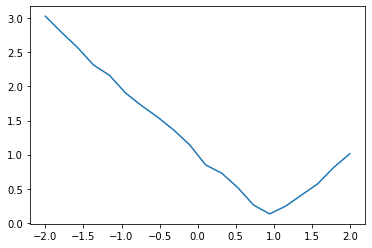

In [109]:
plt.plot(np.linspace(-2,2,20),losses)

In [157]:
# new 
n=200
m=2**9
d=1
s=1
theta_star=np.ones(d)
n_cont = 2
weights = dirichlet.rvs(np.ones(n), size = 1).flatten()
#weights = np.ones(n)
X = np.asarray(sample_gaussian_outl('MC',n,d,s,theta_star,n_cont=n_cont))

theta_estimate = MMD_new(X, weights, m)

Optimization terminated successfully.
         Current function value: 0.032889
         Iterations: 4
         Function evaluations: 15
         Gradient evaluations: 5


In [158]:
theta_estimate

array([0.9199028])

In [113]:
np.mean(X)

1.1946548676551871

<function matplotlib.pyplot.show(*args, **kw)>

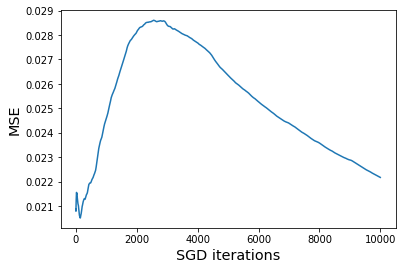

In [111]:
mses = mse(iterations,4,thetas,theta_star)
plt.plot(range(Nstep-1),mses[:,0])
plt.xlabel('SGD iterations',fontsize='x-large')
plt.ylabel('MSE',fontsize='x-large')

plt.show

In [166]:
thetas[3,5631]

-0.17414930930904432

<function matplotlib.pyplot.show(*args, **kw)>

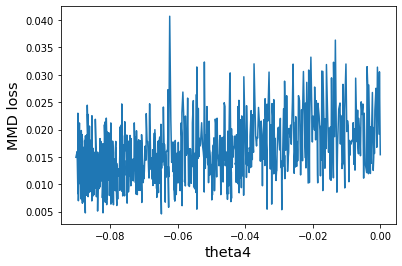

In [44]:
plt.plot(thetas[3,:],losses)
plt.xlabel('theta4',fontsize='x-large')
plt.ylabel('MMD loss',fontsize='x-large')

plt.show

Text(0, 0.5, 'MMD^2 loss')

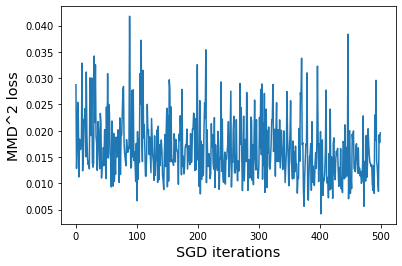

In [54]:
plt.plot(range(Nstep), losses)
plt.xlabel('SGD iterations', fontsize='x-large')
plt.ylabel('MMD^2 loss', fontsize='x-large')

In [68]:
def func(a):
    c = a**2
    d = a**3 
    return c, d

In [7]:
if __name__ == '__main__':
    pool = Pool()              
    temp = pool.map(func, range(5)) 

In [113]:
m = 1000              # number of simulated samples
n = 1500              # number of true samples
theta = np.ones(2)    # true theta
d = len(theta)        # dimensions of data
p = d                 # dimensions of parameter space
s = 2                 # standard deviation of the model
l = -1                # lengthscale (l=-1 for median heuristic)

In [114]:
y = sample_gaussian_outl('MC',m,d,s,theta)
x = sample_gaussian_outl('MC',n,d,s,theta)

In [115]:
kxx = k(x,x,l)
kxy = k(y,x,l)
kyy = k(y,y,l)
k1yy = kyy[1]
k1xy = kxy[1]
k21xx = kxx[2]
grad_g = grad_gen_gaussian(m, theta)

In [116]:
np.shape(k1xy[1])

(1000, 1500)

In [117]:
# check gradient using finite differences
weights = (1/n)*np.ones(n)
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,weights,kxx[0],k(y+0.00000001,x,l)[0],k(y+0.00000001,y+0.00000001,l)[0])-MMD_approx(n,m,weights,kxx[0],kxy[0],kyy[0]))/0.00000001)
print(np.sum(grad_MMD(p,n,m,grad_g,weights,k1yy,k1xy)))

check gradient of the MMD^2 approximation:
-0.00212683204381392
-0.0021268271245530584


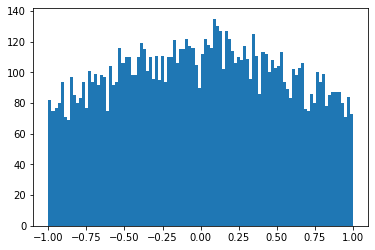

In [24]:
import numpy as np

def normal(x, mu, sig):
    return 1. / (np.sqrt(2 * np.pi) * sig) * np.exp(-0.5 * np.square(x - mu) / np.square(sig))


def trunc_normal(x, mu, sig, bounds=None):
    if bounds is None: 
        bounds = (-np.inf, np.inf)

    norm = normal(x, mu, sig)
    norm[x < bounds[0]] = 0
    norm[x > bounds[1]] = 0

    return norm


def sample_trunc(n, mu, sig, bounds=None):
    """ Sample `n` points from truncated normal distribution """
    x = np.linspace(mu - 5. * sig, mu + 5. * sig, 10000)
    y = trunc_normal(x, mu, sig, bounds)
    y_cum = np.cumsum(y) / y.sum()

    yrand = np.random.rand(n)
    sample = np.interp(yrand, y_cum, x)

    return sample


# Example
import matplotlib.pyplot as plt
samples = sample_trunc(10000, 0, 1, (-1, 1))
plt.hist(samples, bins=100)
plt.show()